
Risk/Return Summary (Net)

                 CAGR  AnnVol  Sharpe    MaxDD  Calmar Sortino
Strategy                                                      
EW             0.2137  0.2030  0.9580  -0.3340  0.6398  1.1924
MinVar         0.1442  0.1462  0.8582  -0.3262  0.4421  1.0040
MV             0.1240  0.1440  0.7455  -0.3507  0.3535  0.8652
ElasticNet MV  0.1241  0.1440  0.7461  -0.3506  0.3539  0.8659
MaxSharpe      0.2012  0.2312  0.8228  -0.4024  0.5001  1.0198
RiskParity     0.1958  0.1891  0.9349  -0.3330  0.5879  1.1384
HRP            0.1663  0.1638  0.9000  -0.3236  0.5140  1.0709
NCO            0.1369  0.1554  0.7757  -0.3263  0.4197  0.9223

Trading & Stability Summary

              Avg Turnover Total Turnover Total Costs Cost % Final Value  \
Strategy                                                                   
EW                  0.0352         2.7134      0.0150             0.0026   
MinVar              0.0258         1.9888      0.0064             0.0019   
MV      

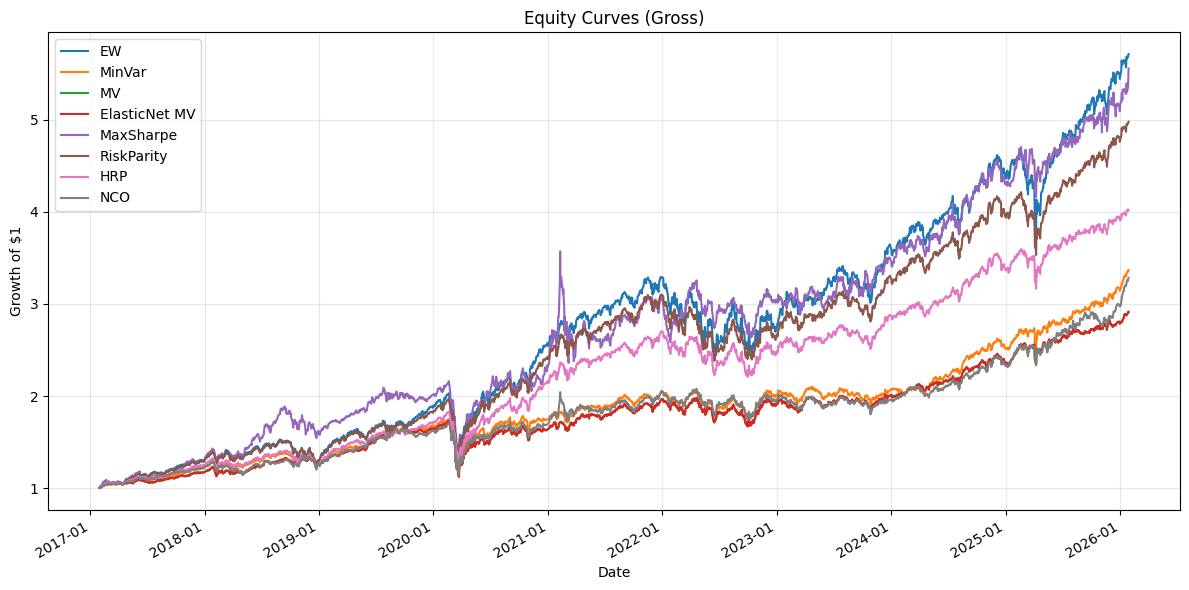

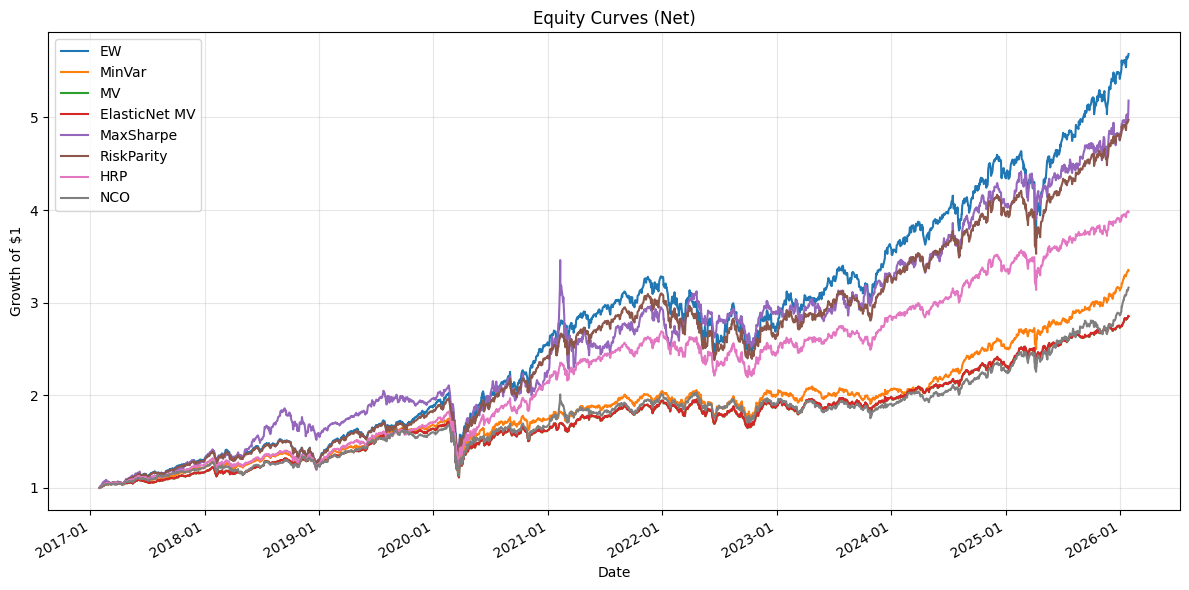

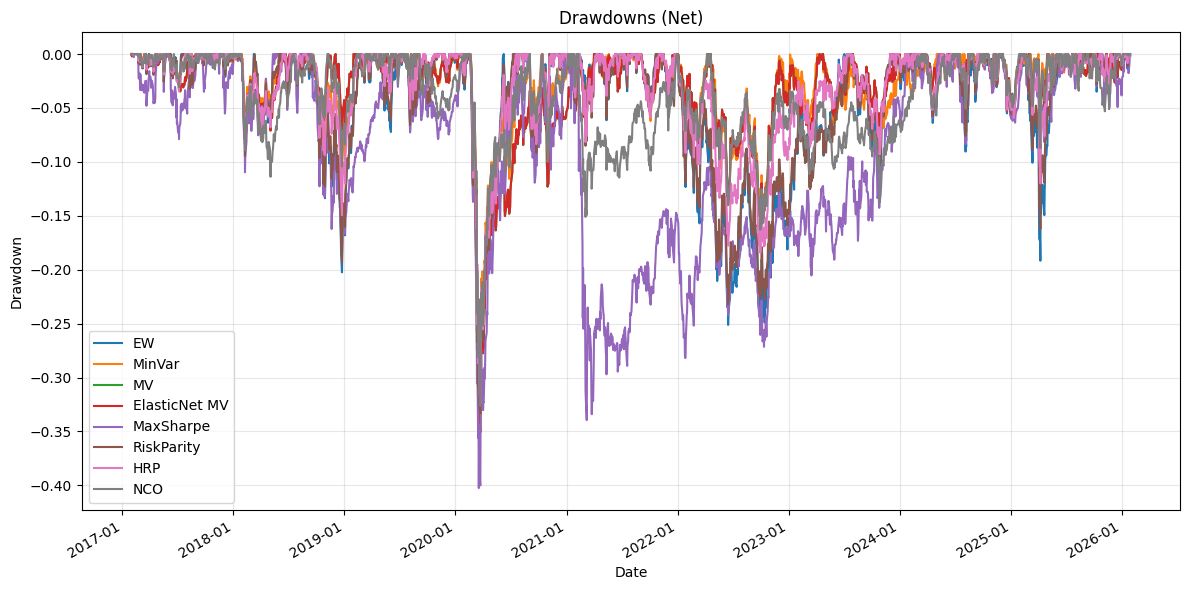

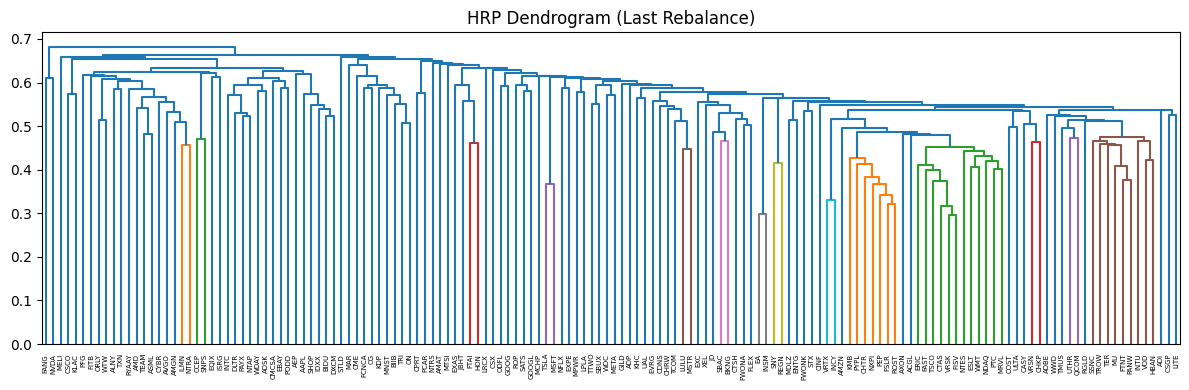

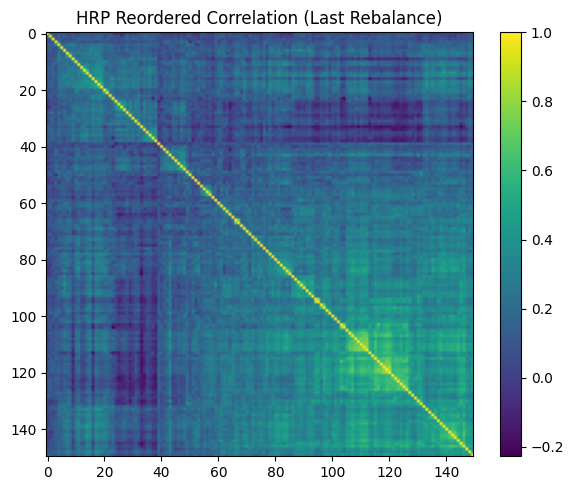


NCO Cluster Membership (Last Rebalance)

Ticker  Cluster
  ESLT        1
  RGLD        1
  COST        2
   WMT        2
   ADP        2
  CTAS        2
  TMUS        2
   PEP        2
  ORLY        2
  MNST        2
  MDLZ        2
   AEP        2
   CME        2
 CMCSA        2
  FAST        2
    EA        2
   KMB        2
  ACGL        2
  PAYX        2
  CHTR        2
  INSM        2
   KHC        2
  TSCO        2
   VOD        2
   KDP        2
   XEL        2
   ROP        2
   TRI        2
  CCEP        2
   EXC        2
   WTW        2
  FISV        2
  CINF        2
  CASY        2
  VRSK        2
  VRSN        2
  EVRG        2
  SBAC        2
  CHKP        2
  QCOM        3
  KLAC        3
  AMGN        3
  MELI        3
  SHOP        3
   SNY        3
  BKNG        3
  ISRG        3
  GILD        3
  NFLX        3
  CSCO        3
  AMAT        3
  LRCX        3
  INTC        3
   TXN        3
  NVDA        3
  AAPL        3
  AVGO        3
  META        3
  ASML        

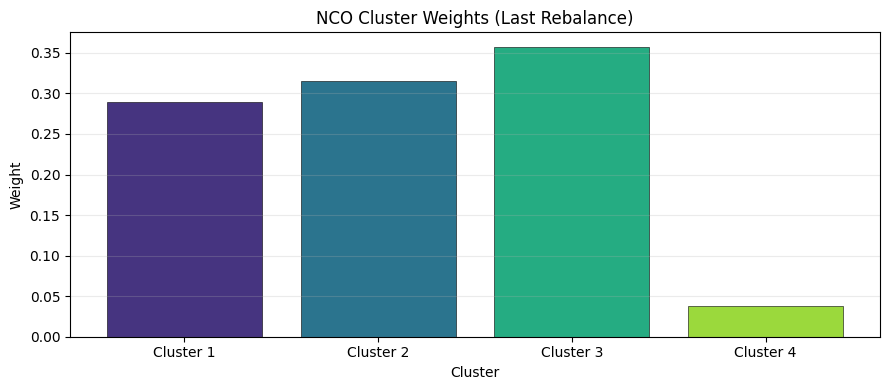

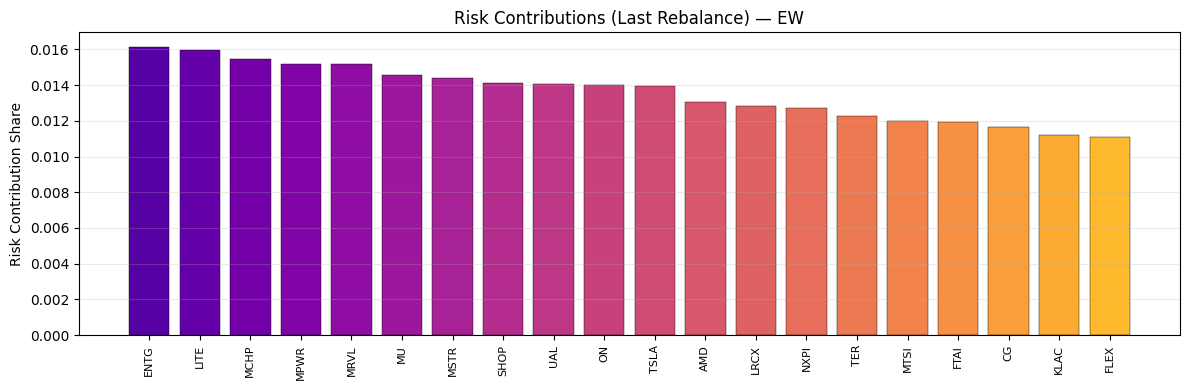

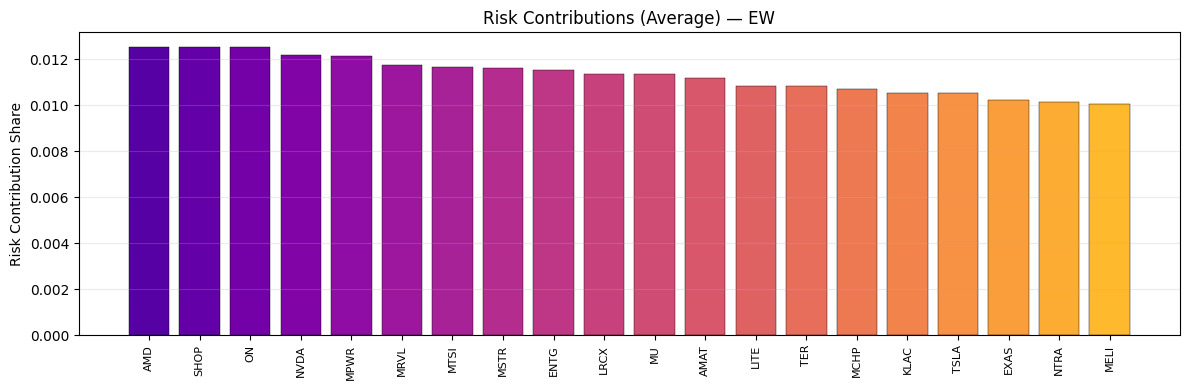

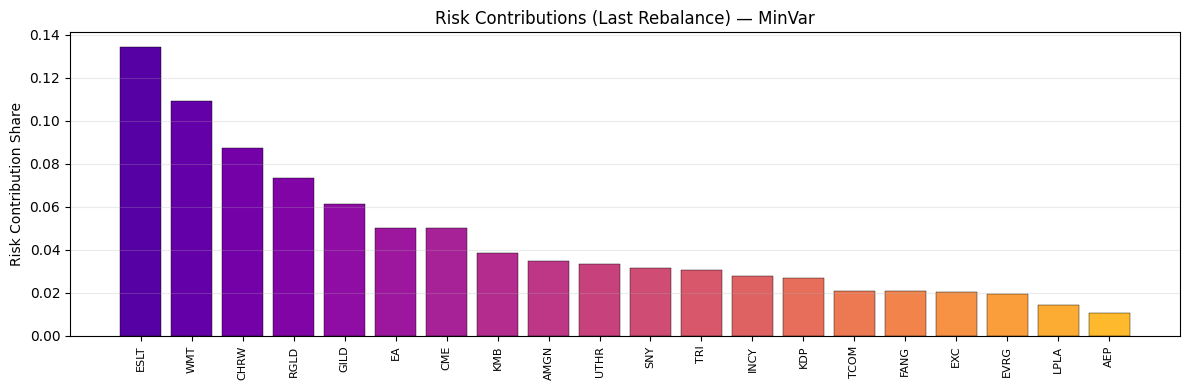

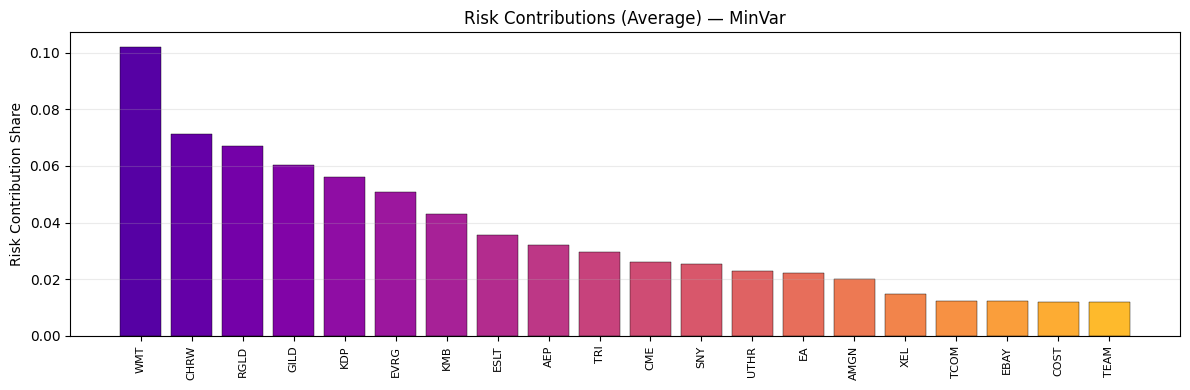

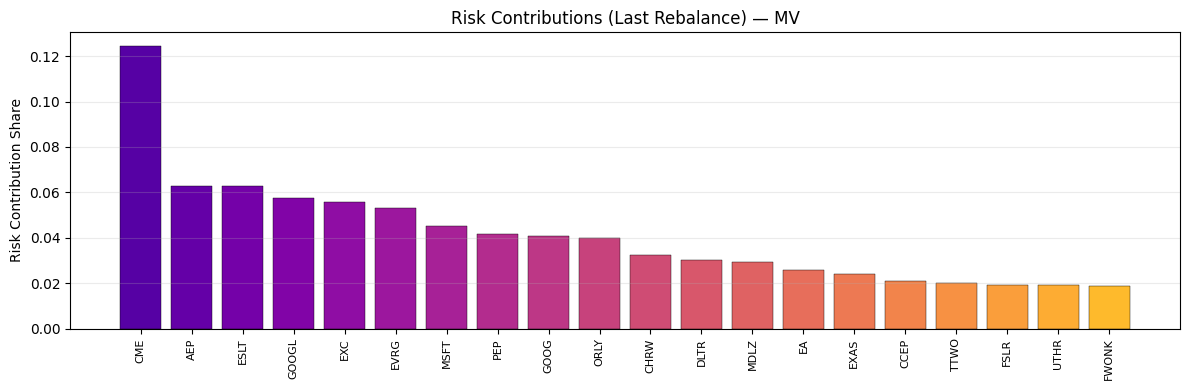

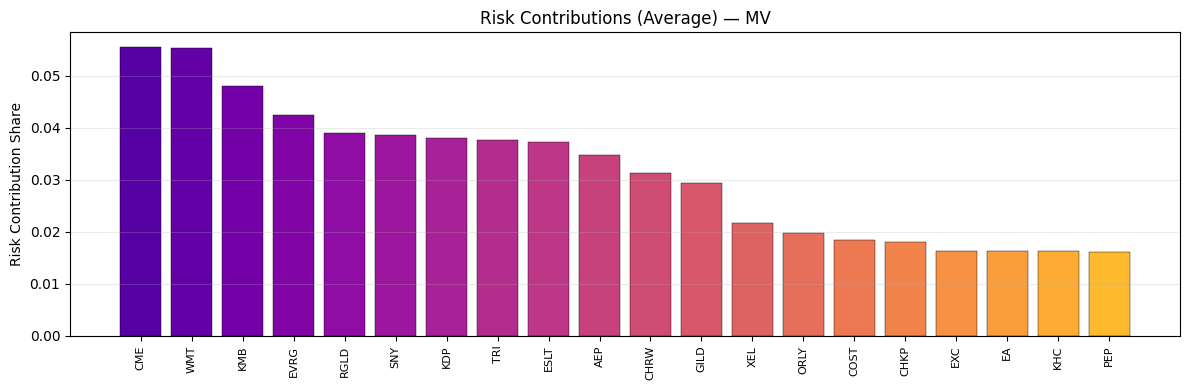

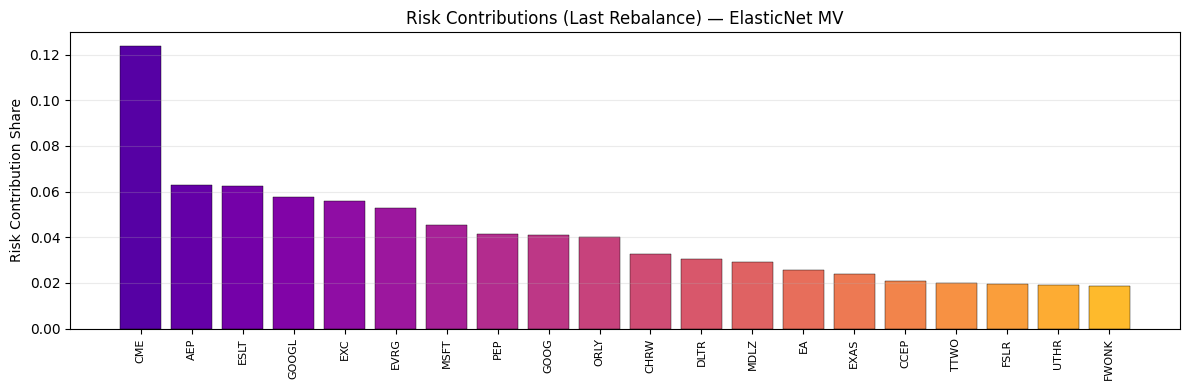

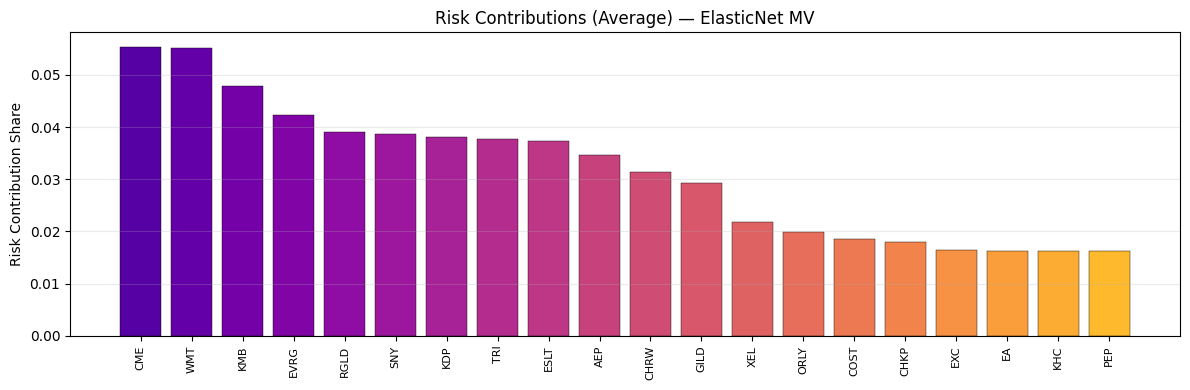

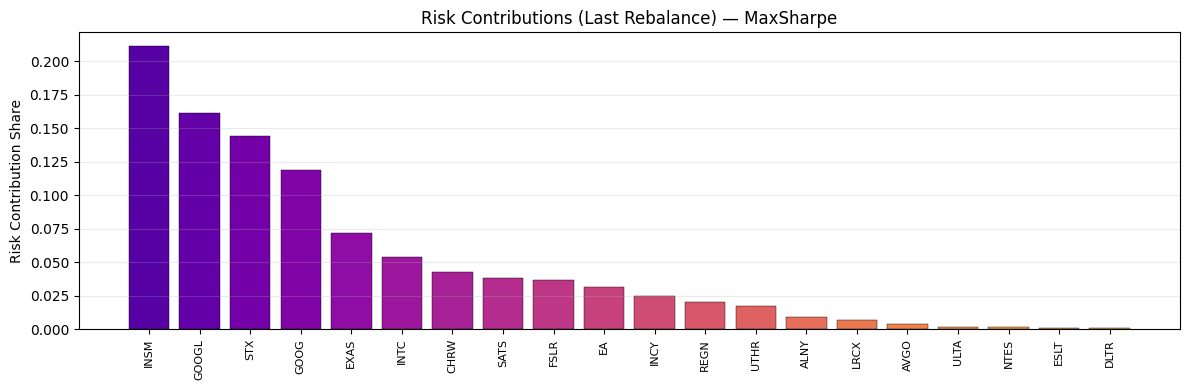

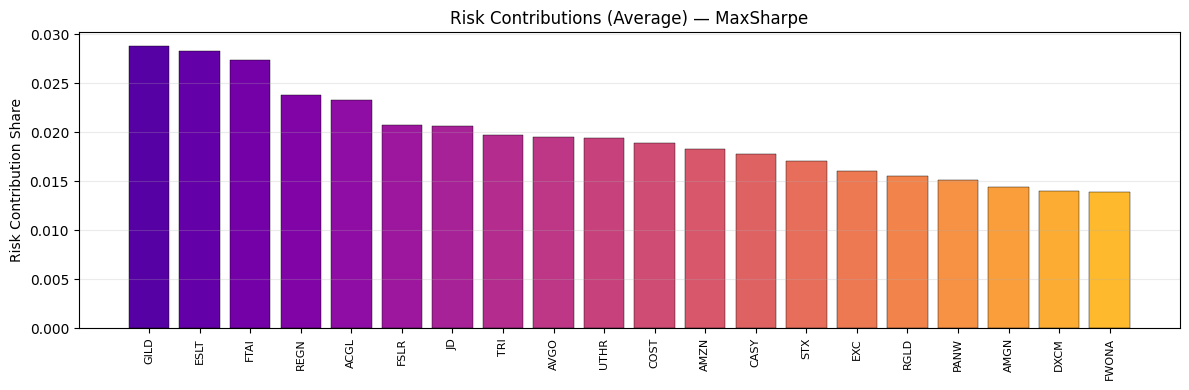

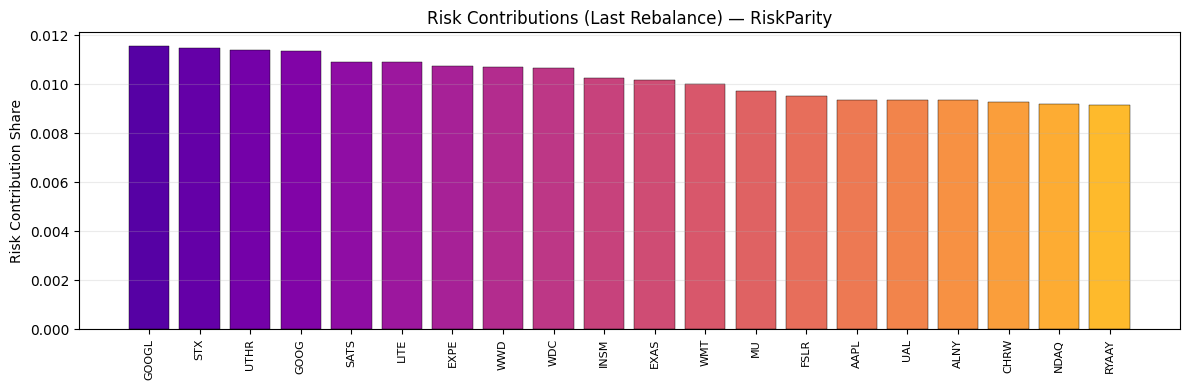

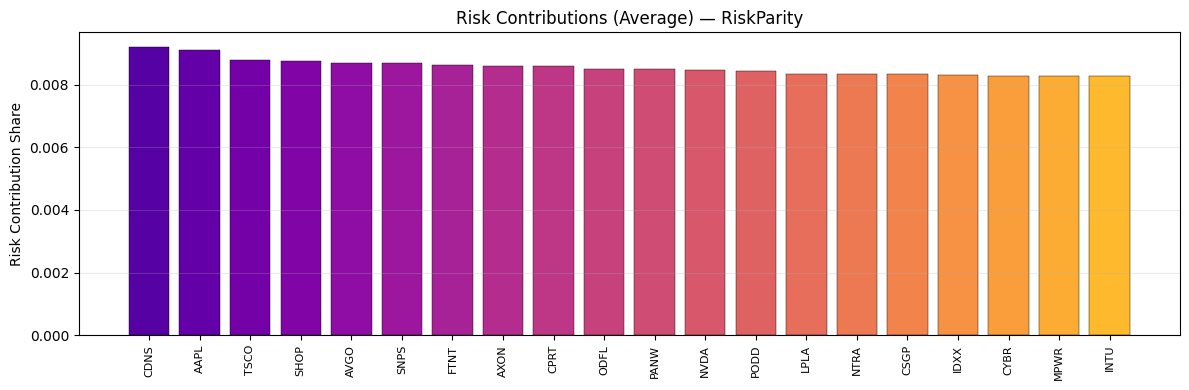

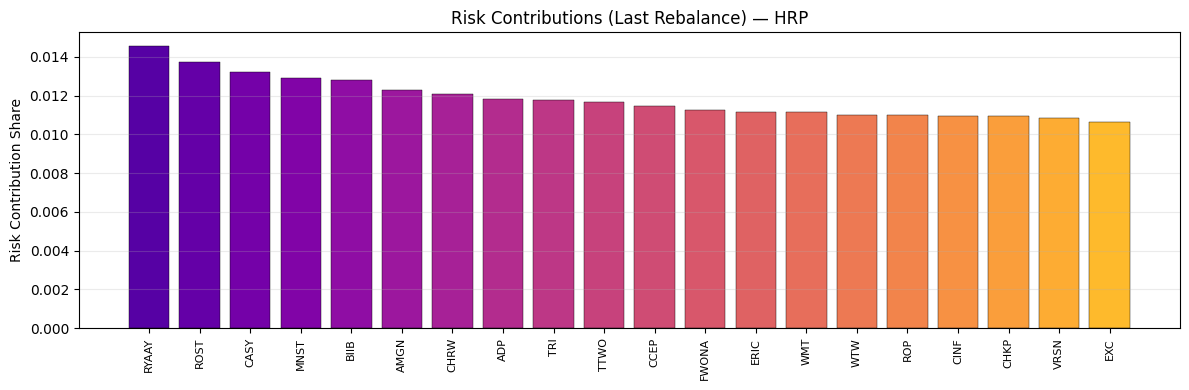

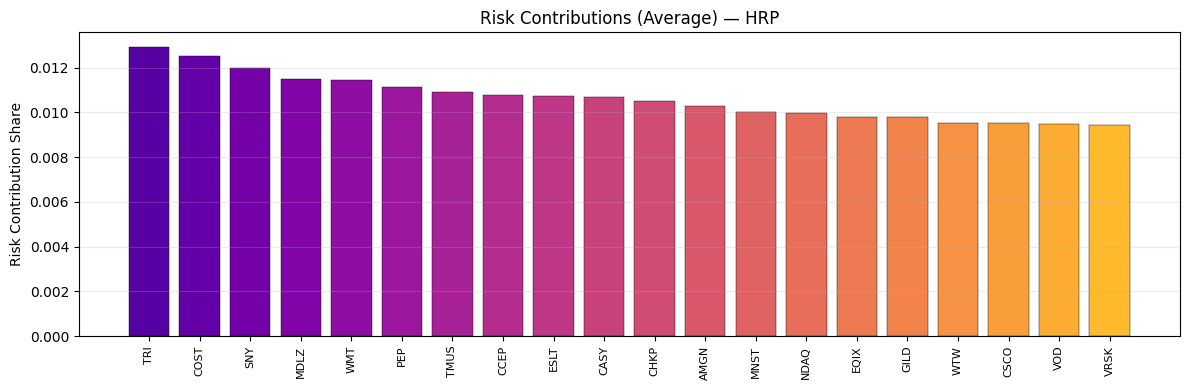

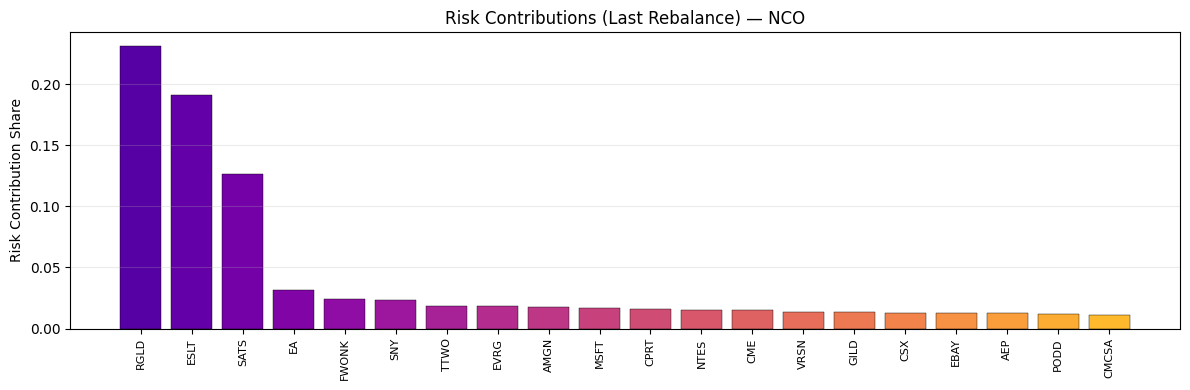

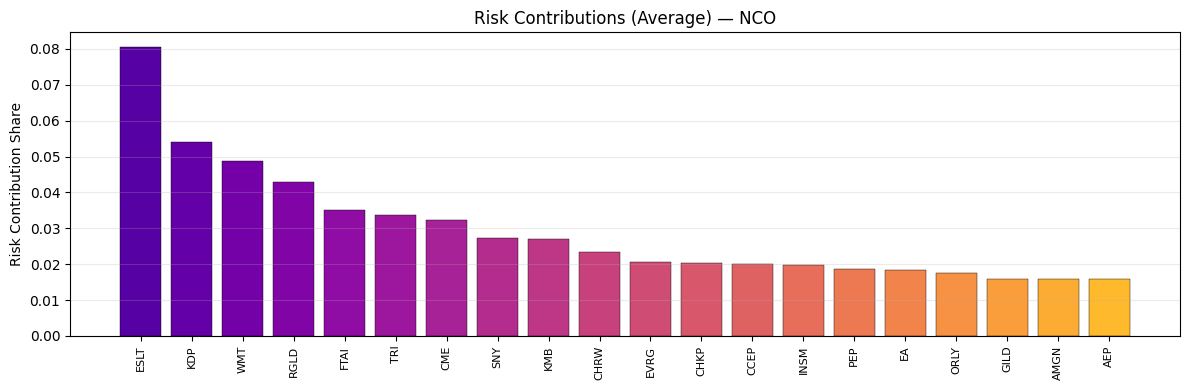

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from matplotlib.dates import DateFormatter

np.set_printoptions(precision=6, suppress=True)

# ============================================================
# CONFIG
# ============================================================
config = {
    "data_path": r"E:\daneshgah\quantitative-finance-lab\data\nasdaq_selected_close_volume.csv",
    "file_type": "csv",                 # "csv" or "parquet"
    "date_col": "Date",
    "start": "2016-01-01",
    "end": None,
    "returns": "simple",                # "simple" or "log"

    # rebalance schedule: pandas resample rule (calendar-based)
    "rebalance_freq": "M",
    "lookback_days": 252,

    "risk_free_annual": 0.02,

    "constraints": {
        "long_only": True,
        "w_min": 0.0,
        "w_max": 0.40,                  # enforced >= 0.30 below (non-NCO)
        "sum_to_one": True
    },

    "costs": {
        "enabled": True,
        "cost_bps_one_way": 10,         # 10 bps
        "fixed_fee_per_trade": 0.0
    },

    "mu_model": {
        # KEY FIX: momentum signal -> winsorize/zscore -> scale to target tangency Sharpe under LW cov
        "type": "momentum_target_sharpe",
        "mode": "6-1",                  # with 252 lookback, use 6-1 (126d skip 21d) - robust
        "winsor_lo": 0.05,
        "winsor_hi": 0.95,
        "target_sharpe_ann": 0.80,      # try 0.40 / 0.60 / 0.80
        "mu_cap_ann": 0.30,             # cap extreme implied excess returns (±30% annual)
        "apply_shrink": False           # if True, shrink mu_excess by mu_shrink_to_zero below
    },

    "optimization": {
        # Mean-Variance (annual scale): maximize mu_excess_ann'w - 0.5*lambda*w'Sigma_ann*w - penalties
        "mv_lambda_annual": 32.0,       # tune 6–30 typically
        "mu_shrink_to_zero": 0.40,      # only applied if mu_model.apply_shrink=True

        # Elastic net MV
        "enet_gamma": 5.0,              # scaled by 1/N internally
        "enet_alpha": 0.8,              # 0=ridge, 1=lasso

        # Stability (inside optimizer)
        "ridge": 1e-4,                  # small L2 on weights

        # penalty interpretation (IMPORTANT):
        # turnover_penalty_bps: additional "slippage bps" per unit L1 turnover, per rebalance.
        # Costs penalty uses cost_bps_one_way similarly. Both are annualized inside the optimizer.
        "turnover_penalty_bps": 0.0,    # start 0; try 5, 10, 25 if needed
        "use_cost_as_penalty": True,    # include transaction cost approx as penalty

        # Numerics
        "solver_order": ["OSQP", "ECOS", "SCS"],
        "jitter": 1e-10,
        "psd_clip_eps": 1e-10,
        "max_iter": 8000
    },

    "blend": {
        "MV": 0.15,
        "ElasticNet MV": 0.15,
        "MaxSharpe": 0.10,
        "MinVar": 0.25,
        "RiskParity": 0.20,
        "HRP": 0.30,
        "NCO": 0.20
    },

    "hrp": {"linkage": "average", "turnover_damp": 0.30},
    "nco": {"K": 4, "linkage": "average", "turnover_damp": 0.10},

    "plots": {"risk_contrib_top_k": 20}
}

# enforce w_max >= 0.30 for non-NCO strategies
config["constraints"]["w_max"] = max(float(config["constraints"]["w_max"]), 0.40)

# ============================================================
# DATA LOADING
# ============================================================
def load_prices(cfg):
    path = cfg["data_path"]
    if cfg["file_type"] == "csv":
        df_try = pd.read_csv(path, header=[0, 1])
        has_multi = isinstance(df_try.columns, pd.MultiIndex)
        has_ohlc = False
        if has_multi:
            level1 = df_try.columns.get_level_values(1)
            has_ohlc = any(x in level1 for x in ["Adj Close", "Close", "AdjClose", "close"])

        if has_ohlc:
            df = df_try
            if cfg["date_col"] in df.columns.get_level_values(0):
                date_col = df[cfg["date_col"]]
                if isinstance(date_col, pd.DataFrame):
                    date_col = date_col.iloc[:, 0]
            else:
                date_col = df.iloc[:, 0]

            field = None
            for cand in ["Adj Close", "Close", "AdjClose", "close"]:
                if cand in level1:
                    field = cand
                    break
            if field is None:
                raise ValueError("No price field found in multiindex columns.")

            prices = df.xs(field, axis=1, level=1)
            prices.index = pd.to_datetime(date_col)
        else:
            df = pd.read_csv(path)
            if cfg["date_col"] in df.columns:
                df[cfg["date_col"]] = pd.to_datetime(df[cfg["date_col"]])
                df = df.set_index(cfg["date_col"])
            prices = df
    else:
        df = pd.read_parquet(path)
        if cfg["date_col"] in df.columns:
            df[cfg["date_col"]] = pd.to_datetime(df[cfg["date_col"]])
            df = df.set_index(cfg["date_col"])
        prices = df

    prices = prices.sort_index()
    prices = prices.apply(pd.to_numeric, errors="coerce").astype(np.float64)
    return prices

prices = load_prices(config)

start = pd.Timestamp(config["start"])
end = pd.Timestamp(config["end"]) if config["end"] else None
prices = prices.loc[prices.index >= start]
if end is not None:
    prices = prices.loc[prices.index <= end]

prices = prices.replace([np.inf, -np.inf], np.nan).ffill()
prices = prices.dropna(axis=1, how="any").dropna(axis=0, how="any")

if config["returns"] == "log":
    returns = np.log(prices).diff()
else:
    returns = prices.pct_change()

returns = returns.replace([np.inf, -np.inf], np.nan).dropna(how="any").astype(np.float64)

tickers = returns.columns.tolist()
n = returns.shape[1]
if n < 2:
    raise ValueError("Need at least two assets after cleaning.")

# ============================================================
# HELPERS
# ============================================================
def print_warn(msg):
    print(f"[WARN] {msg}")

def format_date_axis(ax):
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.figure.autofmt_xdate()

def cov_to_corr(sigma):
    d = np.sqrt(np.diag(sigma))
    d[d == 0] = 1e-12
    corr = sigma / np.outer(d, d)
    return np.clip(corr, -1.0, 1.0)

def make_psd(sigma, eps):
    sigma = 0.5 * (sigma + sigma.T)
    vals, vecs = np.linalg.eigh(sigma)
    vals = np.maximum(vals, eps)
    sigma_psd = (vecs * vals) @ vecs.T
    return 0.5 * (sigma_psd + sigma_psd.T)

def safe_normalize_weights(w, w_min, w_max, long_only):
    w = np.asarray(w, dtype=np.float64).flatten()
    if long_only:
        w = np.maximum(w, 0.0)
    if w_min is not None:
        w = np.maximum(w, w_min)
    if w_max is not None:
        w = np.minimum(w, w_max)
    s = w.sum()
    if (not np.isfinite(s)) or s <= 0:
        return None
    w = w / s
    for _ in range(2):
        if long_only:
            w = np.maximum(w, 0.0)
        if w_min is not None:
            w = np.maximum(w, w_min)
        if w_max is not None:
            w = np.minimum(w, w_max)
        s = w.sum()
        if s <= 0:
            return None
        w = w / s
    return w

def compute_drifted_weights(w, r):
    w = w * (1.0 + r)
    s = w.sum()
    if s <= 0 or (not np.isfinite(s)):
        return None
    return w / s

def constraints_feasible(nn, w_min, w_max, long_only):
    w_min_eff = 0.0 if long_only else (-np.inf if w_min is None else w_min)
    w_max_eff = np.inf if w_max is None else w_max
    if np.isfinite(w_max_eff) and w_max_eff * nn < 1.0 - 1e-9:
        return False
    if np.isfinite(w_min_eff) and w_min_eff * nn > 1.0 + 1e-9:
        return False
    return True

def blend_weights(w_star, w_prev, eta):
    eta = float(np.clip(eta, 0.0, 1.0))
    return (1.0 - eta) * np.asarray(w_star, dtype=np.float64) + eta * np.asarray(w_prev, dtype=np.float64)

# Transaction costs
w_min = float(config["constraints"]["w_min"])
w_max = float(config["constraints"]["w_max"])
long_only = bool(config["constraints"]["long_only"])

rf_daily = (1.0 + config["risk_free_annual"]) ** (1.0 / 252.0) - 1.0

def tc_rate_from_delta(delta):
    if not config["costs"]["enabled"]:
        return 0.0
    c = config["costs"]["cost_bps_one_way"] / 10000.0
    return float(c * np.sum(np.abs(delta)))

def rebalances_per_year(rebal_dates_index):
    if len(rebal_dates_index) < 2:
        return 1.0
    d = pd.to_datetime(rebal_dates_index).values
    gaps = np.diff(d).astype("timedelta64[D]").astype(int)
    med_days = float(np.median(gaps))
    med_days = max(med_days, 1.0)
    return 252.0 / med_days

# ============================================================
# MU: MOMENTUM SIGNAL -> SCALE TO TARGET TANGENCY SHARPE (FIX)
# ============================================================
def momentum_score_from_returns(ret_window: pd.DataFrame, mode="6-1") -> np.ndarray:
    """
    Cross-sectional momentum SCORE at window end.
    Uses geometric cumulative return over lookback, skipping last month if requested.

    mode:
      "6-1": 126d lookback, skip last 21d
      "12-1": 252d lookback, skip last 21d (needs >=273 days)
      "3-0":  63d lookback, skip 0d
    """
    R = ret_window.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    T = len(R)
    if T < 80:
        return R.mean().values.astype(np.float64)

    if mode == "12-1":
        lookback, skip = 252, 21
    elif mode == "6-1":
        lookback, skip = 126, 21
    elif mode == "3-0":
        lookback, skip = 63, 0
    else:
        raise ValueError("Unknown momentum mode")

    if T < lookback + skip + 5:
        lookback = min(lookback, max(63, T - skip - 1))

    R_use = R.iloc[-(lookback + skip):]
    R_mom = R_use.iloc[:-skip] if skip > 0 else R_use

    cum = (1.0 + R_mom).prod(axis=0) - 1.0
    return cum.values.astype(np.float64)

def winsorize_and_zscore(x: np.ndarray, p_lo=0.05, p_hi=0.95) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    lo, hi = np.quantile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    x = x - x.mean()
    return x / (x.std() + 1e-12)

def scale_mu_to_target_sharpe(mu_dir: np.ndarray,
                              cov_ann: np.ndarray,
                              target_sharpe_ann: float,
                              mu_cap_ann: float) -> np.ndarray:
    """
    Scale a direction vector mu_dir so that tangency Sharpe implied by (mu, Sigma) equals target.
    target: sqrt(mu' Sigma^{-1} mu)
    """
    mu = np.asarray(mu_dir, dtype=np.float64).flatten()
    if np.all(np.abs(mu) < 1e-12):
        return np.zeros_like(mu)

    ridge = 1e-8
    A = cov_ann + ridge * np.eye(cov_ann.shape[0])
    try:
        x = np.linalg.solve(A, mu)
    except np.linalg.LinAlgError:
        x = np.linalg.lstsq(A, mu, rcond=None)[0]

    q = float(mu @ x)
    if (not np.isfinite(q)) or q <= 1e-18:
        return np.zeros_like(mu)

    scale = float(target_sharpe_ann) / np.sqrt(q)
    mu_scaled = np.clip(scale * mu, -mu_cap_ann, mu_cap_ann)
    return mu_scaled

# ============================================================
# CVXPY SOLVER CACHE
# ============================================================
cvx_cache = {}

def solve_cvx(prob, var, solver_order, max_iter):
    for solver in solver_order:
        try:
            prob.solve(solver=solver, warm_start=True, max_iter=max_iter)
            if var.value is not None:
                w = np.asarray(var.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w)):
                    return w
        except Exception:
            continue
    return None

def get_mv_solver(nn, w_min, w_max, long_only, mv_lambda, ridge, kappa):
    key = ("mv", nn, w_min, w_max, long_only, mv_lambda, ridge, kappa)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Maximize(
        mu @ w
        - 0.5 * mv_lambda * cp.quad_form(w, S)
        - kappa * cp.norm1(w - w_prev)
        - 0.5 * ridge * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_enet_mv_solver(nn, w_min, w_max, long_only, mv_lambda, ridge, kappa, gamma, alpha):
    key = ("enet_mv", nn, w_min, w_max, long_only, mv_lambda, ridge, kappa, gamma, alpha)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    l1 = cp.norm1(w)
    l2 = cp.sum_squares(w)
    reg = gamma * (alpha * l1 + 0.5 * (1.0 - alpha) * l2)

    obj = cp.Maximize(
        mu @ w
        - 0.5 * mv_lambda * cp.quad_form(w, S)
        - kappa * cp.norm1(w - w_prev)
        - 0.5 * ridge * cp.sum_squares(w)
        - reg
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_minvar_solver(nn, w_min, w_max, long_only, ridge, kappa):
    key = ("minvar", nn, w_min, w_max, long_only, ridge, kappa)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Minimize(
        cp.quad_form(w, S)
        + kappa * cp.norm1(w - w_prev)
        + 0.5 * ridge * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, S, w_prev)
    return prob, w, S, w_prev

# ============================================================
# STRATEGY WEIGHT FUNCTIONS
# ============================================================
solver_order = config["optimization"]["solver_order"]
max_iter = int(config["optimization"]["max_iter"])

def kappa_annual(rebals_per_year_value: float) -> float:
    """
    Annualized L1 turnover penalty coefficient for the optimizer.
    We interpret costs/turnover penalties as per-rebalance bps (or cost bps one-way),
    then multiply by rebals_per_year to match annual mu/cov units.
    """
    k = 0.0
    if config["optimization"].get("use_cost_as_penalty", True) and config["costs"]["enabled"]:
        k += config["costs"]["cost_bps_one_way"] / 10000.0
    k += float(config["optimization"].get("turnover_penalty_bps", 0.0)) / 10000.0
    return float(rebals_per_year_value * k)

def mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    prob, w_var, mu_p, S_p, wprev_p = get_mv_solver(n, w_min, w_max, long_only, lam, ridge, kappa)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def enet_mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    gamma = float(config["optimization"]["enet_gamma"]) / max(n, 1)
    alpha = float(config["optimization"]["enet_alpha"])

    prob, w_var, mu_p, S_p, wprev_p = get_enet_mv_solver(n, w_min, w_max, long_only, lam, ridge, kappa, gamma, alpha)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def minvar_weights(cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    prob, w_var, S_p, wprev_p = get_minvar_solver(n, w_min, w_max, long_only, ridge, kappa)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def max_sharpe_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    """
    Non-convex Sharpe-like optimization using excess expected returns (annual).
    IMPORTANT: mu_excess_ann is already excess -> do NOT subtract rf again.
    """
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None

    w_min_eff = 0.0 if long_only else (-1.0 if w_min is None else w_min)
    w_max_eff = 1.0 if w_max is None else w_max
    bounds = [(w_min_eff, w_max_eff) for _ in range(n)]
    x0 = np.ones(n, dtype=np.float64) / n

    kappa = kappa_annual(rebals_per_year_value)
    ridge = float(config["optimization"]["ridge"])

    mu_use = np.asarray(mu_excess_ann, dtype=np.float64)

    def neg_obj(w):
        w = np.asarray(w, dtype=np.float64)
        if np.any(~np.isfinite(w)):
            return 1e6
        ret = float(mu_use @ w)  # excess annual return
        vol = float(np.sqrt(w @ cov_ann @ w))
        if vol < 1e-12:
            return 1e6
        sharpe = ret / vol
        pen = kappa * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)
        return -sharpe + pen

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    res = minimize(neg_obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": max_iter})
    if (not res.success) or np.any(~np.isfinite(res.x)):
        return None
    return safe_normalize_weights(res.x, w_min, w_max, long_only)

def risk_parity_weights(cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None

    w_min_eff = 0.0 if long_only else (-1.0 if w_min is None else w_min)
    w_max_eff = 1.0 if w_max is None else w_max
    bounds = [(w_min_eff, w_max_eff) for _ in range(n)]
    x0 = np.ones(n, dtype=np.float64) / n

    kappa = kappa_annual(rebals_per_year_value)
    ridge = float(config["optimization"]["ridge"])

    def rp_obj(w):
        w = np.asarray(w, dtype=np.float64)
        pv = float(w @ cov_ann @ w)
        if pv <= 0:
            return 1e6
        mrc = cov_ann @ w
        rc = w * mrc / pv
        target = np.ones(n, dtype=np.float64) / n
        fit = float(np.sum((rc - target) ** 2))
        pen = kappa * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)
        return fit + pen

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    res = minimize(rp_obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": max_iter})
    if (not res.success) or np.any(~np.isfinite(res.x)):
        return None
    return safe_normalize_weights(res.x, w_min, w_max, long_only)

# ============================================================
# HRP
# ============================================================
def correl_distance(corr):
    return np.sqrt(0.5 * (1.0 - corr))

def quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1]).sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

def get_cluster_var(cov, cluster_items):
    sub = cov[np.ix_(cluster_items, cluster_items)]
    d = np.diag(sub).copy()
    d[d <= 1e-18] = 1e-18
    iv = 1.0 / d
    w = iv / iv.sum() if iv.sum() > 0 else np.ones(len(cluster_items)) / len(cluster_items)
    return float(w @ sub @ w)

def recursive_bisect(cov, sort_ix):
    w = pd.Series(1.0, index=sort_ix)
    clusters = [sort_ix]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) <= 1:
            continue
        split = len(cluster) // 2
        c1 = cluster[:split]
        c2 = cluster[split:]
        var1 = get_cluster_var(cov, c1)
        var2 = get_cluster_var(cov, c2)
        alpha = 1.0 - var1 / (var1 + var2) if (var1 + var2) > 0 else 0.5
        w[c1] *= alpha
        w[c2] *= (1.0 - alpha)
        clusters.append(c1)
        clusters.append(c2)
    return w

def hrp_weights(cov_ann, w_prev):
    corr = cov_to_corr(cov_ann)
    dist = correl_distance(corr)
    link = linkage(squareform(dist, checks=False), method=config["hrp"]["linkage"])
    sort_ix = quasi_diag(link)
    w_series = recursive_bisect(cov_ann, sort_ix)
    w_raw = np.zeros(n, dtype=np.float64)
    w_raw[sort_ix] = w_series.values

    eta = float(config["hrp"].get("turnover_damp", 0.30))
    w_blend = (1.0 - eta) * w_raw + eta * w_prev
    w = safe_normalize_weights(w_blend, w_min, w_max, long_only)
    return w, link, corr, sort_ix

# ============================================================
# NCO (NO CAPS: only long-only + sum-to-one)
# ============================================================
def nco_solve_mv_nocaps(mu_excess_ann, cov_ann):
    nn = len(mu_excess_ann)
    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)

    mu.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S.value = np.asarray(cov_ann, dtype=np.float64)

    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])

    prob = cp.Problem(
        cp.Maximize(mu @ w - 0.5 * lam * cp.quad_form(w, S) - 0.5 * ridge * cp.sum_squares(w)),
        [w >= 0, cp.sum(w) == 1]
    )

    w_sol = None
    for solver in solver_order:
        try:
            prob.solve(solver=solver, warm_start=True, max_iter=max_iter)
            if w.value is not None:
                w_sol = np.asarray(w.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w_sol)):
                    break
        except Exception:
            continue

    if w_sol is None:
        return np.ones(nn) / nn
    w_sol = np.maximum(w_sol, 0.0)
    s = w_sol.sum()
    return w_sol / s if s > 0 else np.ones(nn) / nn

def nco_weights(window_returns, mu_excess_ann_full, cov_ann_full, K, linkage_method, w_prev_full):
    nn = len(mu_excess_ann_full)

    corr = cov_to_corr(cov_ann_full)
    dist = correl_distance(corr)
    link = linkage(squareform(dist, checks=False), method=linkage_method)
    K_eff = min(K, nn)
    labels = fcluster(link, K_eff, criterion="maxclust")
    cluster_keys = sorted(list(set(labels)))

    mu_use = np.asarray(mu_excess_ann_full, dtype=np.float64)

    w_intra = np.zeros(nn, dtype=np.float64)
    cluster_returns = []
    cluster_names = []
    cluster_assets = {}

    for k in cluster_keys:
        idxs = np.where(labels == k)[0].tolist()
        cluster_assets[k] = idxs

        if len(idxs) == 1:
            w_k = np.array([1.0])
        else:
            mu_k = mu_use[idxs]
            cov_k = cov_ann_full[np.ix_(idxs, idxs)]
            w_k = nco_solve_mv_nocaps(mu_k, cov_k)

        w_intra[idxs] = w_k
        cluster_returns.append(window_returns.iloc[:, idxs].values @ w_k)
        cluster_names.append(f"Cluster {k}")

    cluster_returns = np.column_stack(cluster_returns)

    # Cluster-level stats from realized cluster returns (annualized)
    mu_c_excess = 252.0 * cluster_returns.mean(axis=0)
    cov_c = 252.0 * np.cov(cluster_returns, rowvar=False, ddof=1).astype(np.float64)
    cov_c = 0.5 * (cov_c + cov_c.T)
    cov_c += config["optimization"]["jitter"] * np.eye(cov_c.shape[0])
    cov_c = make_psd(cov_c, config["optimization"]["psd_clip_eps"])

    w_cluster = nco_solve_mv_nocaps(mu_c_excess, cov_c)

    w_final = np.zeros(nn, dtype=np.float64)
    for i, k in enumerate(cluster_keys):
        idxs = cluster_assets[k]
        w_final[idxs] += w_cluster[i] * w_intra[idxs]

    eta = float(config["nco"].get("turnover_damp", 0.10))
    w_final = (1.0 - eta) * w_final + eta * w_prev_full
    w_final = np.maximum(w_final, 0.0)
    s = w_final.sum()
    w_final = w_final / s if s > 0 else np.ones(nn) / nn

    return w_final, labels, w_cluster, cluster_names

# ============================================================
# ESTIMATION CACHE (LW default; NO LOOKAHEAD: window ends at dt-1)
# ============================================================
rebal_dates = returns.resample(config["rebalance_freq"]).last().index
rebal_dates = rebal_dates.intersection(returns.index)

cache = {}
mu_cfg = config["mu_model"]

for dt in rebal_dates:
    pos = returns.index.get_loc(dt)
    if pos < config["lookback_days"]:
        continue

    # window ends at dt-1 (avoid lookahead), length lookback_days
    window = returns.iloc[pos - config["lookback_days"] : pos]
    if window.shape[0] < config["lookback_days"]:
        continue

    # LW covariance (daily) -> annual
    cov_lw_daily = LedoitWolf().fit(window.values).covariance_.astype(np.float64)
    cov_lw_daily = 0.5 * (cov_lw_daily + cov_lw_daily.T)
    cov_lw_daily += config["optimization"]["jitter"] * np.eye(n)
    cov_lw_daily = make_psd(cov_lw_daily, config["optimization"]["psd_clip_eps"])
    cov_ann = 252.0 * cov_lw_daily

    # MU FIX: momentum score -> winsor/zscore -> scale to target tangency Sharpe => mu_excess_ann
    score = momentum_score_from_returns(window, mode=mu_cfg["mode"])
    z = winsorize_and_zscore(score, mu_cfg["winsor_lo"], mu_cfg["winsor_hi"])
    mu_excess_ann = scale_mu_to_target_sharpe(
        z, cov_ann,
        target_sharpe_ann=float(mu_cfg["target_sharpe_ann"]),
        mu_cap_ann=float(mu_cfg["mu_cap_ann"])
    )

    cache[dt] = {"R": window, "mu_excess_ann": mu_excess_ann, "cov_ann": cov_ann}

rebal_dates = [d for d in rebal_dates if d in cache]
if len(rebal_dates) == 0:
    raise ValueError("No rebalance dates with sufficient lookback data.")

REBALS_PER_YEAR = rebalances_per_year(rebal_dates)

# ============================================================
# BACKTEST (TIMING CLEAN)
# - Start at first rebalance date
# - Use weights held entering dt
# - Drift at dt close
# - If dt is rebalance date: compute new weights using info up to dt-1 and trade at dt close
# - New weights apply from next trading day
# ============================================================
def backtest_strategy(name):
    all_dates = returns.loc[rebal_dates[0]:].index
    rebal_set = set(rebal_dates)

    w = np.ones(n, dtype=np.float64) / n
    gross_value, net_value = 1.0, 1.0

    gross_values, net_values, gross_returns = [], [], []
    weights_rebal = {}
    turnover_list, cost_list = [], []
    fallback_count = 0

    hrp_diag = None
    nco_diag = None

    for dt in all_dates:
        # 1) realize today's return using weights entering the day
        r = returns.loc[dt].values
        port_ret = float(np.dot(w, r))
        gross_value *= (1.0 + port_ret)
        net_value *= (1.0 + port_ret)

        gross_values.append(gross_value)
        net_values.append(net_value)
        gross_returns.append(port_ret)

        # 2) drift to close
        w_drift = compute_drifted_weights(w, r)
        if w_drift is None:
            w_drift = np.ones(n, dtype=np.float64) / n

        # 3) rebalance at close (new weights effective next day)
        if dt in rebal_set:
            stats = cache[dt]
            mu_excess_ann = stats["mu_excess_ann"]
            cov_ann = stats["cov_ann"]
            window = stats["R"]

            # optional additional shrink (OFF by default)
            if config["mu_model"].get("apply_shrink", False):
                shrink = float(config["optimization"].get("mu_shrink_to_zero", 0.0))
                mu_use = (1.0 - shrink) * mu_excess_ann
            else:
                mu_use = mu_excess_ann

            w_pre = w_drift.copy()

            if name == "EW":
                w_tar = np.ones(n, dtype=np.float64) / n

            elif name == "MinVar":
                w_tar = minvar_weights(cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "MV":
                w_tar = mv_weights(mu_use, cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "ElasticNet MV":
                w_tar = enet_mv_weights(mu_use, cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "MaxSharpe":
                w_tar = max_sharpe_weights(mu_use, cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "RiskParity":
                w_tar = risk_parity_weights(cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "HRP":
                w_tar, link, corr, sort_ix = hrp_weights(cov_ann, w_pre)
                hrp_diag = {"link": link, "corr": corr, "sort_ix": sort_ix}

            elif name == "NCO":
                w_tar, labels, w_cluster, cluster_names = nco_weights(
                    window_returns=window,
                    mu_excess_ann_full=mu_use,
                    cov_ann_full=cov_ann,
                    K=config["nco"]["K"],
                    linkage_method=config["nco"]["linkage"],
                    w_prev_full=w_pre
                )
                nco_diag = {"labels": labels, "w_cluster": w_cluster, "cluster_names": cluster_names}
            else:
                w_tar = None

            if w_tar is None or np.any(~np.isfinite(w_tar)):
                print_warn(f"{name} failed on {dt.date()}, fallback to EW")
                w_tar = np.ones(n, dtype=np.float64) / n
                fallback_count += 1

            # user blending
            eta = float(config["blend"].get(name, 0.0))
            w_tar = blend_weights(w_tar, w_pre, eta)

            # enforce caps for all except NCO
            if name != "NCO":
                w_tar = safe_normalize_weights(w_tar, w_min, w_max, long_only)
                if w_tar is None:
                    print_warn(f"{name} infeasible on {dt.date()}, fallback to EW")
                    w_tar = np.ones(n, dtype=np.float64) / n
                    fallback_count += 1
            else:
                w_tar = np.maximum(w_tar, 0.0)
                s = w_tar.sum()
                w_tar = w_tar / s if s > 0 else np.ones(n) / n

            # apply transaction costs at close for trade w_pre -> w_tar
            delta = w_tar - w_pre
            turnover = 0.5 * np.sum(np.abs(delta))
            cost_value = 0.0
            if config["costs"]["enabled"]:
                cost_rate = tc_rate_from_delta(delta)
                cost_value = net_value * cost_rate
                net_value = max(net_value - cost_value, 1e-12)

                if config["costs"]["fixed_fee_per_trade"] > 0:
                    fee = config["costs"]["fixed_fee_per_trade"] * np.count_nonzero(np.abs(delta) > 1e-12)
                    net_value = max(net_value - fee, 1e-12)
                    cost_value += fee

            turnover_list.append(turnover)
            cost_list.append(cost_value)
            weights_rebal[dt] = w_tar

            # new weights apply next day
            w = w_tar
        else:
            w = w_drift

    gross_values = pd.Series(gross_values, index=all_dates, name=f"{name}_gross")
    net_values = pd.Series(net_values, index=all_dates, name=f"{name}_net")
    gross_returns = pd.Series(gross_returns, index=all_dates, name=f"{name}_gross_ret")
    net_returns = net_values.pct_change().fillna(0.0)

    weights_df = pd.DataFrame(weights_rebal).T
    if not weights_df.empty:
        weights_df.columns = tickers

    turnover_s = pd.Series(turnover_list, index=weights_df.index) if len(weights_df) else pd.Series([], dtype=float)
    costs_s = pd.Series(cost_list, index=weights_df.index) if len(weights_df) else pd.Series([], dtype=float)

    return {
        "gross_values": gross_values,
        "net_values": net_values,
        "gross_returns": gross_returns,
        "net_returns": net_returns,
        "weights": weights_df,
        "turnover": turnover_s,
        "costs": costs_s,
        "fallbacks": fallback_count,
        "hrp_diag": hrp_diag,
        "nco_diag": nco_diag
    }

# ============================================================
# RUN STRATEGIES
# ============================================================
strategy_names = ["EW", "MinVar", "MV", "ElasticNet MV", "MaxSharpe", "RiskParity", "HRP", "NCO"]
results = {name: backtest_strategy(name) for name in strategy_names}

# ============================================================
# METRICS
# ============================================================
def calc_drawdown(series):
    peak = series.cummax()
    return series / peak - 1.0

def performance_metrics(net_returns, net_values):
    n_days = len(net_returns)
    years = n_days / 252.0
    cagr = (net_values.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else 0.0
    vol = net_returns.std() * np.sqrt(252.0)
    excess = net_returns - rf_daily
    sharpe = (excess.mean() / net_returns.std()) * np.sqrt(252.0) if net_returns.std() > 0 else np.nan
    dd = calc_drawdown(net_values)
    max_dd = dd.min()
    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan
    downside = net_returns[net_returns < 0]
    sortino = (excess.mean() / downside.std()) * np.sqrt(252.0) if downside.std() > 0 else np.nan
    return cagr, vol, sharpe, max_dd, calmar, sortino

metrics_rows = []
for name, res in results.items():
    cagr, vol, sharpe, max_dd, calmar, sortino = performance_metrics(res["net_returns"], res["net_values"])
    metrics_rows.append([name, cagr, vol, sharpe, max_dd, calmar, sortino])

metrics_df = pd.DataFrame(
    metrics_rows,
    columns=["Strategy", "CAGR", "AnnVol", "Sharpe", "MaxDD", "Calmar", "Sortino"]
).set_index("Strategy")

print("\nRisk/Return Summary (Net)\n")
print(metrics_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

trade_rows = []
for name, res in results.items():
    turnover = res["turnover"]
    costs = res["costs"]
    wdf = res["weights"]
    if len(wdf) > 0:
        hhi = (wdf ** 2).sum(axis=1)
        avg_hhi = float(hhi.mean())
        eff_n = 1.0 / avg_hhi if avg_hhi > 0 else np.nan
    else:
        avg_hhi = np.nan
        eff_n = np.nan
    trade_rows.append([
        name,
        float(turnover.mean()) if len(turnover) else 0.0,
        float(turnover.sum()) if len(turnover) else 0.0,
        float(costs.sum()) if len(costs) else 0.0,
        float(costs.sum() / res["net_values"].iloc[-1]) if len(costs) else 0.0,
        avg_hhi,
        eff_n
    ])

trade_df = pd.DataFrame(
    trade_rows,
    columns=["Strategy", "Avg Turnover", "Total Turnover", "Total Costs", "Cost % Final Value", "Avg HHI", "Effective N"]
).set_index("Strategy")

print("\nTrading & Stability Summary\n")
print(trade_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

print("\nFallback counts per strategy:\n")
for name in strategy_names:
    print(f"{name}: {results[name]['fallbacks']}")

# ============================================================
# PLOTS (DATE AXIS)
# ============================================================
def plot_equity_curves(results_dict, key, title):
    plt.figure(figsize=(12, 6))
    for name, res in results_dict.items():
        s = res[key]
        plt.plot(s.index, s.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.grid(True, alpha=0.3)
    plt.legend()
    format_date_axis(plt.gca())
    plt.tight_layout()
    plt.show()

plot_equity_curves(results, "gross_values", "Equity Curves (Gross)")
plot_equity_curves(results, "net_values", "Equity Curves (Net)")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    dd = calc_drawdown(res["net_values"])
    plt.plot(dd.index, dd.values, label=name)
plt.title("Drawdowns (Net)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.legend()
format_date_axis(plt.gca())
plt.tight_layout()
plt.show()

# ============================================================
# HRP VISUALS (LAST REBALANCE)
# ============================================================
hrp_diag = results["HRP"]["hrp_diag"]
if hrp_diag is not None:
    link = hrp_diag["link"]
    sort_ix = hrp_diag["sort_ix"]
    corr = hrp_diag["corr"]

    plt.figure(figsize=(12, 4))
    dendrogram(link, labels=[tickers[i] for i in sort_ix], leaf_rotation=90)
    plt.title("HRP Dendrogram (Last Rebalance)")
    plt.tight_layout()
    plt.show()

    corr_sorted = corr[np.ix_(sort_ix, sort_ix)]
    plt.figure(figsize=(6, 5))
    plt.imshow(corr_sorted, aspect="auto")
    plt.title("HRP Reordered Correlation (Last Rebalance)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# ============================================================
# NCO VISUALS (LAST REBALANCE) + BETTER BAR COLORS
# ============================================================
nco_diag = results["NCO"]["nco_diag"]
if nco_diag is not None:
    labels = nco_diag["labels"]
    cluster_names = nco_diag["cluster_names"]
    w_cluster = nco_diag["w_cluster"]

    cluster_table = pd.DataFrame({"Ticker": tickers, "Cluster": labels}).sort_values("Cluster")
    print("\nNCO Cluster Membership (Last Rebalance)\n")
    print(cluster_table.to_string(index=False))

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0.15, 0.85, len(w_cluster)))

    plt.figure(figsize=(9, 4))
    plt.bar(cluster_names, w_cluster, color=colors, edgecolor="black", linewidth=0.4)
    plt.title("NCO Cluster Weights (Last Rebalance)")
    plt.xlabel("Cluster")
    plt.ylabel("Weight")
    plt.grid(True, alpha=0.25, axis="y")
    plt.tight_layout()
    plt.show()

# ============================================================
# RISK CONTRIBUTIONS (BARPLOTS): LAST + AVERAGE
# ============================================================
def risk_contributions(w, cov_ann):
    w = np.asarray(w, dtype=np.float64)
    pv = float(w @ cov_ann @ w)
    if pv <= 1e-18:
        return np.ones_like(w) / len(w)
    mrc = cov_ann @ w
    rc = w * mrc / pv
    rc = np.maximum(rc, 0.0)
    s = rc.sum()
    return rc / s if s > 0 else np.ones_like(w) / len(w)

def plot_rc_bar(rc, labels_list, title, top_k=20):
    rc = np.asarray(rc, dtype=np.float64)
    order = np.argsort(-rc)[:min(top_k, len(rc))]
    rc_top = rc[order]
    lab_top = [labels_list[i] for i in order]

    cmap = plt.cm.plasma
    colors = cmap(np.linspace(0.15, 0.85, len(rc_top)))

    plt.figure(figsize=(12, 4))
    plt.bar(lab_top, rc_top, color=colors, edgecolor="black", linewidth=0.3)
    plt.title(title)
    plt.ylabel("Risk Contribution Share")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, alpha=0.25, axis="y")
    plt.tight_layout()
    plt.show()

top_k = int(config["plots"]["risk_contrib_top_k"])

for name in strategy_names:
    wdf = results[name]["weights"]
    if wdf.empty:
        continue

    last_dt = wdf.index[-1]
    cov_last = cache[last_dt]["cov_ann"]
    w_last = wdf.iloc[-1].values
    rc_last = risk_contributions(w_last, cov_last)
    plot_rc_bar(rc_last, tickers, f"Risk Contributions (Last Rebalance) — {name}", top_k=top_k)

    rc_list = []
    for dt in wdf.index:
        cov_dt = cache[dt]["cov_ann"]
        rc_dt = risk_contributions(wdf.loc[dt].values, cov_dt)
        rc_list.append(rc_dt)
    rc_avg = np.mean(np.vstack(rc_list), axis=0)
    plot_rc_bar(rc_avg, tickers, f"Risk Contributions (Average) — {name}", top_k=top_k)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from matplotlib.dates import DateFormatter

np.set_printoptions(precision=6, suppress=True)

# ============================================================
# CONFIG
# ============================================================
config = {
    "data_path": r"E:\daneshgah\quantitative-finance-lab\data\nasdaq_selected_close_volume.csv",
    "file_type": "csv",                 # "csv" or "parquet"
    "date_col": "Date",
    "start": "2010-01-01",
    "end": None,
    "returns": "simple",                # "simple" or "log"

    # rebalance schedule: pandas resample rule (calendar-based)
    "rebalance_freq": "M",
    "lookback_days": 252,

    "risk_free_annual": 0.02,

    "constraints": {
        "long_only": True,
        "w_min": 0.0,
        "w_max": 0.40,                  # enforced >= 0.30 below (non-NCO)
        "sum_to_one": True
    },

    "costs": {
        "enabled": True,
        "cost_bps_one_way": 10,         # 10 bps
        "fixed_fee_per_trade": 0.0
    },

    "mu_model": {
        # KEY FIX: momentum signal -> winsorize/zscore -> scale to target tangency Sharpe under LW cov
        "type": "momentum_target_sharpe",
        "mode": "6-1",                  # with 252 lookback, use 6-1 (126d skip 21d) - robust
        "winsor_lo": 0.05,
        "winsor_hi": 0.95,
        "target_sharpe_ann": 0.80,      # try 0.40 / 0.60 / 0.80
        "mu_cap_ann": 0.30,             # cap extreme implied excess returns (±30% annual)
        "apply_shrink": False           # if True, shrink mu_excess by mu_shrink_to_zero below
    },

    "optimization": {
        # Mean-Variance (annual scale): maximize mu_excess_ann'w - 0.5*lambda*w'Sigma_ann*w - penalties
        "mv_lambda_annual": 32.0,       # tune 6–30 typically
        "mu_shrink_to_zero": 0.40,      # only applied if mu_model.apply_shrink=True

        # Elastic net MV
        "enet_gamma": 5.0,              # scaled by 1/N internally
        "enet_alpha": 0.8,              # 0=ridge, 1=lasso

        # Stability (inside optimizer)
        "ridge": 1e-4,                  # small L2 on weights

        # penalty interpretation (IMPORTANT):
        # turnover_penalty_bps: additional "slippage bps" per unit L1 turnover, per rebalance.
        # Costs penalty uses cost_bps_one_way similarly. Both are annualized inside the optimizer.
        "turnover_penalty_bps": 0.0,    # start 0; try 5, 10, 25 if needed
        "use_cost_as_penalty": True,    # include transaction cost approx as penalty

        # Numerics
        "solver_order": ["OSQP", "ECOS", "SCS"],
        "jitter": 1e-10,
        "psd_clip_eps": 1e-10,
        "max_iter": 8000
    },

    "blend": {
        "MV": 0.15,
        "ElasticNet MV": 0.15,
        "MaxSharpe": 0.10,
        "MinVar": 0.25,
        "RiskParity": 0.20,
        "HRP": 0.30,
        "NCO": 0.20
    },

    "hrp": {"linkage": "average", "turnover_damp": 0.30},
    "nco": {"K": 4, "linkage": "average", "turnover_damp": 0.10},

    "plots": {"risk_contrib_top_k": 20}
}

# enforce w_max >= 0.30 for non-NCO strategies
config["constraints"]["w_max"] = max(float(config["constraints"]["w_max"]), 0.40)

# ============================================================
# DATA LOADING
# ============================================================
def load_prices(cfg):
    path = cfg["data_path"]
    if cfg["file_type"] == "csv":
        df_try = pd.read_csv(path, header=[0, 1])
        has_multi = isinstance(df_try.columns, pd.MultiIndex)
        has_ohlc = False
        if has_multi:
            level1 = df_try.columns.get_level_values(1)
            has_ohlc = any(x in level1 for x in ["Adj Close", "Close", "AdjClose", "close"])

        if has_ohlc:
            df = df_try
            if cfg["date_col"] in df.columns.get_level_values(0):
                date_col = df[cfg["date_col"]]
                if isinstance(date_col, pd.DataFrame):
                    date_col = date_col.iloc[:, 0]
            else:
                date_col = df.iloc[:, 0]

            field = None
            for cand in ["Adj Close", "Close", "AdjClose", "close"]:
                if cand in level1:
                    field = cand
                    break
            if field is None:
                raise ValueError("No price field found in multiindex columns.")

            prices = df.xs(field, axis=1, level=1)
            prices.index = pd.to_datetime(date_col)
        else:
            df = pd.read_csv(path)
            if cfg["date_col"] in df.columns:
                df[cfg["date_col"]] = pd.to_datetime(df[cfg["date_col"]])
                df = df.set_index(cfg["date_col"])
            prices = df
    else:
        df = pd.read_parquet(path)
        if cfg["date_col"] in df.columns:
            df[cfg["date_col"]] = pd.to_datetime(df[cfg["date_col"]])
            df = df.set_index(cfg["date_col"])
        prices = df

    prices = prices.sort_index()
    prices = prices.apply(pd.to_numeric, errors="coerce").astype(np.float64)
    return prices

prices = load_prices(config)

start = pd.Timestamp(config["start"])
end = pd.Timestamp(config["end"]) if config["end"] else None
prices = prices.loc[prices.index >= start]
if end is not None:
    prices = prices.loc[prices.index <= end]

prices = prices.replace([np.inf, -np.inf], np.nan).ffill()
prices = prices.dropna(axis=1, how="any").dropna(axis=0, how="any")

if config["returns"] == "log":
    returns = np.log(prices).diff()
else:
    returns = prices.pct_change()

returns = returns.replace([np.inf, -np.inf], np.nan).dropna(how="any").astype(np.float64)

tickers = returns.columns.tolist()
n = returns.shape[1]
if n < 2:
    raise ValueError("Need at least two assets after cleaning.")

# ============================================================
# HELPERS
# ============================================================
def print_warn(msg):
    print(f"[WARN] {msg}")

def format_date_axis(ax):
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.figure.autofmt_xdate()

def cov_to_corr(sigma):
    d = np.sqrt(np.diag(sigma))
    d[d == 0] = 1e-12
    corr = sigma / np.outer(d, d)
    return np.clip(corr, -1.0, 1.0)

def make_psd(sigma, eps):
    sigma = 0.5 * (sigma + sigma.T)
    vals, vecs = np.linalg.eigh(sigma)
    vals = np.maximum(vals, eps)
    sigma_psd = (vecs * vals) @ vecs.T
    return 0.5 * (sigma_psd + sigma_psd.T)

def safe_normalize_weights(w, w_min, w_max, long_only):
    w = np.asarray(w, dtype=np.float64).flatten()
    if long_only:
        w = np.maximum(w, 0.0)
    if w_min is not None:
        w = np.maximum(w, w_min)
    if w_max is not None:
        w = np.minimum(w, w_max)
    s = w.sum()
    if (not np.isfinite(s)) or s <= 0:
        return None
    w = w / s
    for _ in range(2):
        if long_only:
            w = np.maximum(w, 0.0)
        if w_min is not None:
            w = np.maximum(w, w_min)
        if w_max is not None:
            w = np.minimum(w, w_max)
        s = w.sum()
        if s <= 0:
            return None
        w = w / s
    return w

def compute_drifted_weights(w, r):
    w = w * (1.0 + r)
    s = w.sum()
    if s <= 0 or (not np.isfinite(s)):
        return None
    return w / s

def constraints_feasible(nn, w_min, w_max, long_only):
    w_min_eff = 0.0 if long_only else (-np.inf if w_min is None else w_min)
    w_max_eff = np.inf if w_max is None else w_max
    if np.isfinite(w_max_eff) and w_max_eff * nn < 1.0 - 1e-9:
        return False
    if np.isfinite(w_min_eff) and w_min_eff * nn > 1.0 + 1e-9:
        return False
    return True

def blend_weights(w_star, w_prev, eta):
    eta = float(np.clip(eta, 0.0, 1.0))
    return (1.0 - eta) * np.asarray(w_star, dtype=np.float64) + eta * np.asarray(w_prev, dtype=np.float64)

# Transaction costs
w_min = float(config["constraints"]["w_min"])
w_max = float(config["constraints"]["w_max"])
long_only = bool(config["constraints"]["long_only"])

rf_daily = (1.0 + config["risk_free_annual"]) ** (1.0 / 252.0) - 1.0

def tc_rate_from_delta(delta):
    if not config["costs"]["enabled"]:
        return 0.0
    c = config["costs"]["cost_bps_one_way"] / 10000.0
    return float(c * np.sum(np.abs(delta)))

def rebalances_per_year(rebal_dates_index):
    if len(rebal_dates_index) < 2:
        return 1.0
    d = pd.to_datetime(rebal_dates_index).values
    gaps = np.diff(d).astype("timedelta64[D]").astype(int)
    med_days = float(np.median(gaps))
    med_days = max(med_days, 1.0)
    return 252.0 / med_days

# ============================================================
# MU: MOMENTUM SIGNAL -> SCALE TO TARGET TANGENCY SHARPE (FIX)
# ============================================================
def momentum_score_from_returns(ret_window: pd.DataFrame, mode="6-1") -> np.ndarray:
    """
    Cross-sectional momentum SCORE at window end.
    Uses geometric cumulative return over lookback, skipping last month if requested.

    mode:
      "6-1": 126d lookback, skip last 21d
      "12-1": 252d lookback, skip last 21d (needs >=273 days)
      "3-0":  63d lookback, skip 0d
    """
    R = ret_window.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    T = len(R)
    if T < 80:
        return R.mean().values.astype(np.float64)

    if mode == "12-1":
        lookback, skip = 252, 21
    elif mode == "6-1":
        lookback, skip = 126, 21
    elif mode == "3-0":
        lookback, skip = 63, 0
    else:
        raise ValueError("Unknown momentum mode")

    if T < lookback + skip + 5:
        lookback = min(lookback, max(63, T - skip - 1))

    R_use = R.iloc[-(lookback + skip):]
    R_mom = R_use.iloc[:-skip] if skip > 0 else R_use

    cum = (1.0 + R_mom).prod(axis=0) - 1.0
    return cum.values.astype(np.float64)

def winsorize_and_zscore(x: np.ndarray, p_lo=0.05, p_hi=0.95) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    lo, hi = np.quantile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    x = x - x.mean()
    return x / (x.std() + 1e-12)

def scale_mu_to_target_sharpe(mu_dir: np.ndarray,
                              cov_ann: np.ndarray,
                              target_sharpe_ann: float,
                              mu_cap_ann: float) -> np.ndarray:
    """
    Scale a direction vector mu_dir so that tangency Sharpe implied by (mu, Sigma) equals target.
    target: sqrt(mu' Sigma^{-1} mu)
    """
    mu = np.asarray(mu_dir, dtype=np.float64).flatten()
    if np.all(np.abs(mu) < 1e-12):
        return np.zeros_like(mu)

    ridge = 1e-8
    A = cov_ann + ridge * np.eye(cov_ann.shape[0])
    try:
        x = np.linalg.solve(A, mu)
    except np.linalg.LinAlgError:
        x = np.linalg.lstsq(A, mu, rcond=None)[0]

    q = float(mu @ x)
    if (not np.isfinite(q)) or q <= 1e-18:
        return np.zeros_like(mu)

    scale = float(target_sharpe_ann) / np.sqrt(q)
    mu_scaled = np.clip(scale * mu, -mu_cap_ann, mu_cap_ann)
    return mu_scaled

# ============================================================
# CVXPY SOLVER CACHE
# ============================================================
cvx_cache = {}

def solve_cvx(prob, var, solver_order, max_iter):
    for solver in solver_order:
        try:
            prob.solve(solver=solver, warm_start=True, max_iter=max_iter)
            if var.value is not None:
                w = np.asarray(var.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w)):
                    return w
        except Exception:
            continue
    return None

def get_mv_solver(nn, w_min, w_max, long_only, mv_lambda, ridge, kappa):
    key = ("mv", nn, w_min, w_max, long_only, mv_lambda, ridge, kappa)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Maximize(
        mu @ w
        - 0.5 * mv_lambda * cp.quad_form(w, S)
        - kappa * cp.norm1(w - w_prev)
        - 0.5 * ridge * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_enet_mv_solver(nn, w_min, w_max, long_only, mv_lambda, ridge, kappa, gamma, alpha):
    key = ("enet_mv", nn, w_min, w_max, long_only, mv_lambda, ridge, kappa, gamma, alpha)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    l1 = cp.norm1(w)
    l2 = cp.sum_squares(w)
    reg = gamma * (alpha * l1 + 0.5 * (1.0 - alpha) * l2)

    obj = cp.Maximize(
        mu @ w
        - 0.5 * mv_lambda * cp.quad_form(w, S)
        - kappa * cp.norm1(w - w_prev)
        - 0.5 * ridge * cp.sum_squares(w)
        - reg
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_minvar_solver(nn, w_min, w_max, long_only, ridge, kappa):
    key = ("minvar", nn, w_min, w_max, long_only, ridge, kappa)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)

    obj = cp.Minimize(
        cp.quad_form(w, S)
        + kappa * cp.norm1(w - w_prev)
        + 0.5 * ridge * cp.sum_squares(w)
    )
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, S, w_prev)
    return prob, w, S, w_prev

# ============================================================
# STRATEGY WEIGHT FUNCTIONS
# ============================================================
solver_order = config["optimization"]["solver_order"]
max_iter = int(config["optimization"]["max_iter"])

def kappa_annual(rebals_per_year_value: float) -> float:
    """
    Annualized L1 turnover penalty coefficient for the optimizer.
    We interpret costs/turnover penalties as per-rebalance bps (or cost bps one-way),
    then multiply by rebals_per_year to match annual mu/cov units.
    """
    k = 0.0
    if config["optimization"].get("use_cost_as_penalty", True) and config["costs"]["enabled"]:
        k += config["costs"]["cost_bps_one_way"] / 10000.0
    k += float(config["optimization"].get("turnover_penalty_bps", 0.0)) / 10000.0
    return float(rebals_per_year_value * k)

def mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    prob, w_var, mu_p, S_p, wprev_p = get_mv_solver(n, w_min, w_max, long_only, lam, ridge, kappa)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def enet_mv_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None
    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    gamma = float(config["optimization"]["enet_gamma"]) / max(n, 1)
    alpha = float(config["optimization"]["enet_alpha"])

    prob, w_var, mu_p, S_p, wprev_p = get_enet_mv_solver(n, w_min, w_max, long_only, lam, ridge, kappa, gamma, alpha)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def minvar_weights(cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None
    ridge = float(config["optimization"]["ridge"])
    kappa = kappa_annual(rebals_per_year_value)

    prob, w_var, S_p, wprev_p = get_minvar_solver(n, w_min, w_max, long_only, ridge, kappa)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    w = solve_cvx(prob, w_var, solver_order, max_iter)
    if w is None:
        return None
    return safe_normalize_weights(w, w_min, w_max, long_only)

def max_sharpe_weights(mu_excess_ann, cov_ann, w_prev, rebals_per_year_value):
    """
    Non-convex Sharpe-like optimization using excess expected returns (annual).
    IMPORTANT: mu_excess_ann is already excess -> do NOT subtract rf again.
    """
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None

    w_min_eff = 0.0 if long_only else (-1.0 if w_min is None else w_min)
    w_max_eff = 1.0 if w_max is None else w_max
    bounds = [(w_min_eff, w_max_eff) for _ in range(n)]
    x0 = np.ones(n, dtype=np.float64) / n

    kappa = kappa_annual(rebals_per_year_value)
    ridge = float(config["optimization"]["ridge"])

    mu_use = np.asarray(mu_excess_ann, dtype=np.float64)

    def neg_obj(w):
        w = np.asarray(w, dtype=np.float64)
        if np.any(~np.isfinite(w)):
            return 1e6
        ret = float(mu_use @ w)  # excess annual return
        vol = float(np.sqrt(w @ cov_ann @ w))
        if vol < 1e-12:
            return 1e6
        sharpe = ret / vol
        pen = kappa * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)
        return -sharpe + pen

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    res = minimize(neg_obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": max_iter})
    if (not res.success) or np.any(~np.isfinite(res.x)):
        return None
    return safe_normalize_weights(res.x, w_min, w_max, long_only)

def risk_parity_weights(cov_ann, w_prev, rebals_per_year_value):
    if not constraints_feasible(n, w_min, w_max, long_only):
        return None

    w_min_eff = 0.0 if long_only else (-1.0 if w_min is None else w_min)
    w_max_eff = 1.0 if w_max is None else w_max
    bounds = [(w_min_eff, w_max_eff) for _ in range(n)]
    x0 = np.ones(n, dtype=np.float64) / n

    kappa = kappa_annual(rebals_per_year_value)
    ridge = float(config["optimization"]["ridge"])

    def rp_obj(w):
        w = np.asarray(w, dtype=np.float64)
        pv = float(w @ cov_ann @ w)
        if pv <= 0:
            return 1e6
        mrc = cov_ann @ w
        rc = w * mrc / pv
        target = np.ones(n, dtype=np.float64) / n
        fit = float(np.sum((rc - target) ** 2))
        pen = kappa * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)
        return fit + pen

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    res = minimize(rp_obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": max_iter})
    if (not res.success) or np.any(~np.isfinite(res.x)):
        return None
    return safe_normalize_weights(res.x, w_min, w_max, long_only)

# ============================================================
# HRP
# ============================================================
def correl_distance(corr):
    return np.sqrt(0.5 * (1.0 - corr))

def quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1]).sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

def get_cluster_var(cov, cluster_items):
    sub = cov[np.ix_(cluster_items, cluster_items)]
    d = np.diag(sub).copy()
    d[d <= 1e-18] = 1e-18
    iv = 1.0 / d
    w = iv / iv.sum() if iv.sum() > 0 else np.ones(len(cluster_items)) / len(cluster_items)
    return float(w @ sub @ w)

def recursive_bisect(cov, sort_ix):
    w = pd.Series(1.0, index=sort_ix)
    clusters = [sort_ix]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) <= 1:
            continue
        split = len(cluster) // 2
        c1 = cluster[:split]
        c2 = cluster[split:]
        var1 = get_cluster_var(cov, c1)
        var2 = get_cluster_var(cov, c2)
        alpha = 1.0 - var1 / (var1 + var2) if (var1 + var2) > 0 else 0.5
        w[c1] *= alpha
        w[c2] *= (1.0 - alpha)
        clusters.append(c1)
        clusters.append(c2)
    return w

def hrp_weights(cov_ann, w_prev):
    corr = cov_to_corr(cov_ann)
    dist = correl_distance(corr)
    link = linkage(squareform(dist, checks=False), method=config["hrp"]["linkage"])
    sort_ix = quasi_diag(link)
    w_series = recursive_bisect(cov_ann, sort_ix)
    w_raw = np.zeros(n, dtype=np.float64)
    w_raw[sort_ix] = w_series.values

    eta = float(config["hrp"].get("turnover_damp", 0.30))
    w_blend = (1.0 - eta) * w_raw + eta * w_prev
    w = safe_normalize_weights(w_blend, w_min, w_max, long_only)
    return w, link, corr, sort_ix

# ============================================================
# NCO (NO CAPS: only long-only + sum-to-one)
# ============================================================
def nco_solve_mv_nocaps(mu_excess_ann, cov_ann):
    nn = len(mu_excess_ann)
    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)

    mu.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S.value = np.asarray(cov_ann, dtype=np.float64)

    lam = float(config["optimization"]["mv_lambda_annual"])
    ridge = float(config["optimization"]["ridge"])

    prob = cp.Problem(
        cp.Maximize(mu @ w - 0.5 * lam * cp.quad_form(w, S) - 0.5 * ridge * cp.sum_squares(w)),
        [w >= 0, cp.sum(w) == 1]
    )

    w_sol = None
    for solver in solver_order:
        try:
            prob.solve(solver=solver, warm_start=True, max_iter=max_iter)
            if w.value is not None:
                w_sol = np.asarray(w.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w_sol)):
                    break
        except Exception:
            continue

    if w_sol is None:
        return np.ones(nn) / nn
    w_sol = np.maximum(w_sol, 0.0)
    s = w_sol.sum()
    return w_sol / s if s > 0 else np.ones(nn) / nn

def nco_weights(window_returns, mu_excess_ann_full, cov_ann_full, K, linkage_method, w_prev_full):
    nn = len(mu_excess_ann_full)

    corr = cov_to_corr(cov_ann_full)
    dist = correl_distance(corr)
    link = linkage(squareform(dist, checks=False), method=linkage_method)
    K_eff = min(K, nn)
    labels = fcluster(link, K_eff, criterion="maxclust")
    cluster_keys = sorted(list(set(labels)))

    mu_use = np.asarray(mu_excess_ann_full, dtype=np.float64)

    w_intra = np.zeros(nn, dtype=np.float64)
    cluster_returns = []
    cluster_names = []
    cluster_assets = {}

    for k in cluster_keys:
        idxs = np.where(labels == k)[0].tolist()
        cluster_assets[k] = idxs

        if len(idxs) == 1:
            w_k = np.array([1.0])
        else:
            mu_k = mu_use[idxs]
            cov_k = cov_ann_full[np.ix_(idxs, idxs)]
            w_k = nco_solve_mv_nocaps(mu_k, cov_k)

        w_intra[idxs] = w_k
        cluster_returns.append(window_returns.iloc[:, idxs].values @ w_k)
        cluster_names.append(f"Cluster {k}")

    cluster_returns = np.column_stack(cluster_returns)

    # Cluster-level stats from realized cluster returns (annualized)
    mu_c_excess = 252.0 * cluster_returns.mean(axis=0)
    cov_c = 252.0 * np.cov(cluster_returns, rowvar=False, ddof=1).astype(np.float64)
    cov_c = 0.5 * (cov_c + cov_c.T)
    cov_c += config["optimization"]["jitter"] * np.eye(cov_c.shape[0])
    cov_c = make_psd(cov_c, config["optimization"]["psd_clip_eps"])

    w_cluster = nco_solve_mv_nocaps(mu_c_excess, cov_c)

    w_final = np.zeros(nn, dtype=np.float64)
    for i, k in enumerate(cluster_keys):
        idxs = cluster_assets[k]
        w_final[idxs] += w_cluster[i] * w_intra[idxs]

    eta = float(config["nco"].get("turnover_damp", 0.10))
    w_final = (1.0 - eta) * w_final + eta * w_prev_full
    w_final = np.maximum(w_final, 0.0)
    s = w_final.sum()
    w_final = w_final / s if s > 0 else np.ones(nn) / nn

    return w_final, labels, w_cluster, cluster_names

# ============================================================
# ESTIMATION CACHE (LW default; NO LOOKAHEAD: window ends at dt-1)
# ============================================================
rebal_dates = returns.resample(config["rebalance_freq"]).last().index
rebal_dates = rebal_dates.intersection(returns.index)

cache = {}
mu_cfg = config["mu_model"]

for dt in rebal_dates:
    pos = returns.index.get_loc(dt)
    if pos < config["lookback_days"]:
        continue

    # window ends at dt-1 (avoid lookahead), length lookback_days
    window = returns.iloc[pos - config["lookback_days"] : pos]
    if window.shape[0] < config["lookback_days"]:
        continue

    # LW covariance (daily) -> annual
    cov_lw_daily = LedoitWolf().fit(window.values).covariance_.astype(np.float64)
    cov_lw_daily = 0.5 * (cov_lw_daily + cov_lw_daily.T)
    cov_lw_daily += config["optimization"]["jitter"] * np.eye(n)
    cov_lw_daily = make_psd(cov_lw_daily, config["optimization"]["psd_clip_eps"])
    cov_ann = 252.0 * cov_lw_daily

    # MU FIX: momentum score -> winsor/zscore -> scale to target tangency Sharpe => mu_excess_ann
    score = momentum_score_from_returns(window, mode=mu_cfg["mode"])
    z = winsorize_and_zscore(score, mu_cfg["winsor_lo"], mu_cfg["winsor_hi"])
    mu_excess_ann = scale_mu_to_target_sharpe(
        z, cov_ann,
        target_sharpe_ann=float(mu_cfg["target_sharpe_ann"]),
        mu_cap_ann=float(mu_cfg["mu_cap_ann"])
    )

    cache[dt] = {"R": window, "mu_excess_ann": mu_excess_ann, "cov_ann": cov_ann}

rebal_dates = [d for d in rebal_dates if d in cache]
if len(rebal_dates) == 0:
    raise ValueError("No rebalance dates with sufficient lookback data.")

REBALS_PER_YEAR = rebalances_per_year(rebal_dates)

# ============================================================
# BACKTEST (TIMING CLEAN)
# - Start at first rebalance date
# - Use weights held entering dt
# - Drift at dt close
# - If dt is rebalance date: compute new weights using info up to dt-1 and trade at dt close
# - New weights apply from next trading day
# ============================================================
def backtest_strategy(name):
    all_dates = returns.loc[rebal_dates[0]:].index
    rebal_set = set(rebal_dates)

    w = np.ones(n, dtype=np.float64) / n
    gross_value, net_value = 1.0, 1.0

    gross_values, net_values, gross_returns = [], [], []
    weights_rebal = {}
    turnover_list, cost_list = [], []
    fallback_count = 0

    hrp_diag = None
    nco_diag = None

    for dt in all_dates:
        # 1) realize today's return using weights entering the day
        r = returns.loc[dt].values
        port_ret = float(np.dot(w, r))
        gross_value *= (1.0 + port_ret)
        net_value *= (1.0 + port_ret)

        gross_values.append(gross_value)
        net_values.append(net_value)
        gross_returns.append(port_ret)

        # 2) drift to close
        w_drift = compute_drifted_weights(w, r)
        if w_drift is None:
            w_drift = np.ones(n, dtype=np.float64) / n

        # 3) rebalance at close (new weights effective next day)
        if dt in rebal_set:
            stats = cache[dt]
            mu_excess_ann = stats["mu_excess_ann"]
            cov_ann = stats["cov_ann"]
            window = stats["R"]

            # optional additional shrink (OFF by default)
            if config["mu_model"].get("apply_shrink", False):
                shrink = float(config["optimization"].get("mu_shrink_to_zero", 0.0))
                mu_use = (1.0 - shrink) * mu_excess_ann
            else:
                mu_use = mu_excess_ann

            w_pre = w_drift.copy()

            if name == "EW":
                w_tar = np.ones(n, dtype=np.float64) / n

            elif name == "MinVar":
                w_tar = minvar_weights(cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "MV":
                w_tar = mv_weights(mu_use, cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "ElasticNet MV":
                w_tar = enet_mv_weights(mu_use, cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "MaxSharpe":
                w_tar = max_sharpe_weights(mu_use, cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "RiskParity":
                w_tar = risk_parity_weights(cov_ann, w_pre, REBALS_PER_YEAR)

            elif name == "HRP":
                w_tar, link, corr, sort_ix = hrp_weights(cov_ann, w_pre)
                hrp_diag = {"link": link, "corr": corr, "sort_ix": sort_ix}

            elif name == "NCO":
                w_tar, labels, w_cluster, cluster_names = nco_weights(
                    window_returns=window,
                    mu_excess_ann_full=mu_use,
                    cov_ann_full=cov_ann,
                    K=config["nco"]["K"],
                    linkage_method=config["nco"]["linkage"],
                    w_prev_full=w_pre
                )
                nco_diag = {"labels": labels, "w_cluster": w_cluster, "cluster_names": cluster_names}
            else:
                w_tar = None

            if w_tar is None or np.any(~np.isfinite(w_tar)):
                print_warn(f"{name} failed on {dt.date()}, fallback to EW")
                w_tar = np.ones(n, dtype=np.float64) / n
                fallback_count += 1

            # user blending
            eta = float(config["blend"].get(name, 0.0))
            w_tar = blend_weights(w_tar, w_pre, eta)

            # enforce caps for all except NCO
            if name != "NCO":
                w_tar = safe_normalize_weights(w_tar, w_min, w_max, long_only)
                if w_tar is None:
                    print_warn(f"{name} infeasible on {dt.date()}, fallback to EW")
                    w_tar = np.ones(n, dtype=np.float64) / n
                    fallback_count += 1
            else:
                w_tar = np.maximum(w_tar, 0.0)
                s = w_tar.sum()
                w_tar = w_tar / s if s > 0 else np.ones(n) / n

            # apply transaction costs at close for trade w_pre -> w_tar
            delta = w_tar - w_pre
            turnover = 0.5 * np.sum(np.abs(delta))
            cost_value = 0.0
            if config["costs"]["enabled"]:
                cost_rate = tc_rate_from_delta(delta)
                cost_value = net_value * cost_rate
                net_value = max(net_value - cost_value, 1e-12)

                if config["costs"]["fixed_fee_per_trade"] > 0:
                    fee = config["costs"]["fixed_fee_per_trade"] * np.count_nonzero(np.abs(delta) > 1e-12)
                    net_value = max(net_value - fee, 1e-12)
                    cost_value += fee

            turnover_list.append(turnover)
            cost_list.append(cost_value)
            weights_rebal[dt] = w_tar

            # new weights apply next day
            w = w_tar
        else:
            w = w_drift

    gross_values = pd.Series(gross_values, index=all_dates, name=f"{name}_gross")
    net_values = pd.Series(net_values, index=all_dates, name=f"{name}_net")
    gross_returns = pd.Series(gross_returns, index=all_dates, name=f"{name}_gross_ret")
    net_returns = net_values.pct_change().fillna(0.0)

    weights_df = pd.DataFrame(weights_rebal).T
    if not weights_df.empty:
        weights_df.columns = tickers

    turnover_s = pd.Series(turnover_list, index=weights_df.index) if len(weights_df) else pd.Series([], dtype=float)
    costs_s = pd.Series(cost_list, index=weights_df.index) if len(weights_df) else pd.Series([], dtype=float)

    return {
        "gross_values": gross_values,
        "net_values": net_values,
        "gross_returns": gross_returns,
        "net_returns": net_returns,
        "weights": weights_df,
        "turnover": turnover_s,
        "costs": costs_s,
        "fallbacks": fallback_count,
        "hrp_diag": hrp_diag,
        "nco_diag": nco_diag
    }

# ============================================================
# RUN STRATEGIES
# ============================================================
strategy_names = ["EW", "MinVar", "MV", "ElasticNet MV", "MaxSharpe", "RiskParity", "HRP", "NCO"]
results = {name: backtest_strategy(name) for name in strategy_names}

# ============================================================
# METRICS
# ============================================================
def calc_drawdown(series):
    peak = series.cummax()
    return series / peak - 1.0

def performance_metrics(net_returns, net_values):
    n_days = len(net_returns)
    years = n_days / 252.0
    cagr = (net_values.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else 0.0
    vol = net_returns.std() * np.sqrt(252.0)
    excess = net_returns - rf_daily
    sharpe = (excess.mean() / net_returns.std()) * np.sqrt(252.0) if net_returns.std() > 0 else np.nan
    dd = calc_drawdown(net_values)
    max_dd = dd.min()
    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan
    downside = net_returns[net_returns < 0]
    sortino = (excess.mean() / downside.std()) * np.sqrt(252.0) if downside.std() > 0 else np.nan
    return cagr, vol, sharpe, max_dd, calmar, sortino

metrics_rows = []
for name, res in results.items():
    cagr, vol, sharpe, max_dd, calmar, sortino = performance_metrics(res["net_returns"], res["net_values"])
    metrics_rows.append([name, cagr, vol, sharpe, max_dd, calmar, sortino])

metrics_df = pd.DataFrame(
    metrics_rows,
    columns=["Strategy", "CAGR", "AnnVol", "Sharpe", "MaxDD", "Calmar", "Sortino"]
).set_index("Strategy")

print("\nRisk/Return Summary (Net)\n")
print(metrics_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

trade_rows = []
for name, res in results.items():
    turnover = res["turnover"]
    costs = res["costs"]
    wdf = res["weights"]
    if len(wdf) > 0:
        hhi = (wdf ** 2).sum(axis=1)
        avg_hhi = float(hhi.mean())
        eff_n = 1.0 / avg_hhi if avg_hhi > 0 else np.nan
    else:
        avg_hhi = np.nan
        eff_n = np.nan
    trade_rows.append([
        name,
        float(turnover.mean()) if len(turnover) else 0.0,
        float(turnover.sum()) if len(turnover) else 0.0,
        float(costs.sum()) if len(costs) else 0.0,
        float(costs.sum() / res["net_values"].iloc[-1]) if len(costs) else 0.0,
        avg_hhi,
        eff_n
    ])

trade_df = pd.DataFrame(
    trade_rows,
    columns=["Strategy", "Avg Turnover", "Total Turnover", "Total Costs", "Cost % Final Value", "Avg HHI", "Effective N"]
).set_index("Strategy")

print("\nTrading & Stability Summary\n")
print(trade_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

print("\nFallback counts per strategy:\n")
for name in strategy_names:
    print(f"{name}: {results[name]['fallbacks']}")

# ============================================================
# PLOTS (DATE AXIS)
# ============================================================
def plot_equity_curves(results_dict, key, title):
    plt.figure(figsize=(12, 6))
    for name, res in results_dict.items():
        s = res[key]
        plt.plot(s.index, s.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.grid(True, alpha=0.3)
    plt.legend()
    format_date_axis(plt.gca())
    plt.tight_layout()
    plt.show()

plot_equity_curves(results, "gross_values", "Equity Curves (Gross)")
plot_equity_curves(results, "net_values", "Equity Curves (Net)")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    dd = calc_drawdown(res["net_values"])
    plt.plot(dd.index, dd.values, label=name)
plt.title("Drawdowns (Net)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.legend()
format_date_axis(plt.gca())
plt.tight_layout()
plt.show()

# ============================================================
# HRP VISUALS (LAST REBALANCE)
# ============================================================
hrp_diag = results["HRP"]["hrp_diag"]
if hrp_diag is not None:
    link = hrp_diag["link"]
    sort_ix = hrp_diag["sort_ix"]
    corr = hrp_diag["corr"]

    plt.figure(figsize=(12, 4))
    dendrogram(link, labels=[tickers[i] for i in sort_ix], leaf_rotation=90)
    plt.title("HRP Dendrogram (Last Rebalance)")
    plt.tight_layout()
    plt.show()

    corr_sorted = corr[np.ix_(sort_ix, sort_ix)]
    plt.figure(figsize=(6, 5))
    plt.imshow(corr_sorted, aspect="auto")
    plt.title("HRP Reordered Correlation (Last Rebalance)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# ============================================================
# NCO VISUALS (LAST REBALANCE) + BETTER BAR COLORS
# ============================================================
nco_diag = results["NCO"]["nco_diag"]
if nco_diag is not None:
    labels = nco_diag["labels"]
    cluster_names = nco_diag["cluster_names"]
    w_cluster = nco_diag["w_cluster"]

    cluster_table = pd.DataFrame({"Ticker": tickers, "Cluster": labels}).sort_values("Cluster")
    print("\nNCO Cluster Membership (Last Rebalance)\n")
    print(cluster_table.to_string(index=False))

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0.15, 0.85, len(w_cluster)))

    plt.figure(figsize=(9, 4))
    plt.bar(cluster_names, w_cluster, color=colors, edgecolor="black", linewidth=0.4)
    plt.title("NCO Cluster Weights (Last Rebalance)")
    plt.xlabel("Cluster")
    plt.ylabel("Weight")
    plt.grid(True, alpha=0.25, axis="y")
    plt.tight_layout()
    plt.show()

# ============================================================
# RISK CONTRIBUTIONS (BARPLOTS): LAST + AVERAGE
# ============================================================
def risk_contributions(w, cov_ann):
    w = np.asarray(w, dtype=np.float64)
    pv = float(w @ cov_ann @ w)
    if pv <= 1e-18:
        return np.ones_like(w) / len(w)
    mrc = cov_ann @ w
    rc = w * mrc / pv
    rc = np.maximum(rc, 0.0)
    s = rc.sum()
    return rc / s if s > 0 else np.ones_like(w) / len(w)

def plot_rc_bar(rc, labels_list, title, top_k=20):
    rc = np.asarray(rc, dtype=np.float64)
    order = np.argsort(-rc)[:min(top_k, len(rc))]
    rc_top = rc[order]
    lab_top = [labels_list[i] for i in order]

    cmap = plt.cm.plasma
    colors = cmap(np.linspace(0.15, 0.85, len(rc_top)))

    plt.figure(figsize=(12, 4))
    plt.bar(lab_top, rc_top, color=colors, edgecolor="black", linewidth=0.3)
    plt.title(title)
    plt.ylabel("Risk Contribution Share")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, alpha=0.25, axis="y")
    plt.tight_layout()
    plt.show()

top_k = int(config["plots"]["risk_contrib_top_k"])

for name in strategy_names:
    wdf = results[name]["weights"]
    if wdf.empty:
        continue

    last_dt = wdf.index[-1]
    cov_last = cache[last_dt]["cov_ann"]
    w_last = wdf.iloc[-1].values
    rc_last = risk_contributions(w_last, cov_last)
    plot_rc_bar(rc_last, tickers, f"Risk Contributions (Last Rebalance) — {name}", top_k=top_k)

    rc_list = []
    for dt in wdf.index:
        cov_dt = cache[dt]["cov_ann"]
        rc_dt = risk_contributions(wdf.loc[dt].values, cov_dt)
        rc_list.append(rc_dt)
    rc_avg = np.mean(np.vstack(rc_list), axis=0)
    plot_rc_bar(rc_avg, tickers, f"Risk Contributions (Average) — {name}", top_k=top_k)

KeyboardInterrupt: 